In [1]:
## Basic stuff
%load_ext autoreload
%autoreload
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
display(HTML("""<style>div.output_area{max-height:10000px;overflow:scroll;}</style>"""))

## Python Version
import sys
print("Python: {0}".format(sys.version))

from combine import combine
from fsUtils import moveFile
from ioUtils import getFile, saveFile
from timeUtils import clock, elapsed
from pandas import DataFrame, Series, read_csv, to_numeric


import datetime as dt
start = dt.datetime.now()
print("Notebook Last Run Initiated: "+str(start))

Python: 3.7.3 (default, Mar 27 2019, 16:54:48) 
[Clang 4.0.1 (tags/RELEASE_401/final)]
Notebook Last Run Initiated: 2019-11-19 11:28:54.352035


# Load Data

In [38]:
load = True
if load is False:
    names_basics = read_csv("imdb/name.basics.tsv", sep='\t')
    names = names_basics[["nconst", "primaryName"]]
    names.columns = ['nconst', 'Actor']
    saveFile(idata=names, ifile="imdb/names.p")
else:
    names = getFile("imdb/names.p")
names.head()

,nconst,Actor
0,nm0000001,Fred Astaire
1,nm0000002,Lauren Bacall
2,nm0000003,Brigitte Bardot
3,nm0000004,John Belushi
4,nm0000005,Ingmar Bergman


In [39]:
load = True
if load is False:
    title_basics = read_csv("imdb/title.basics.tsv", sep='\t')
    print(title_basics.shape)
    titles = title_basics[title_basics["titleType"].isin(["movie"])][["tconst", "primaryTitle", "startYear"]]
    print(titles.shape)
    titles.columns = ["tconst", "Title", "Year"]
    saveFile(idata=titles, ifile="imdb/titles.p")
else:
    titles = getFile("imdb/titles.p", debug=True)
titles.head()

Loading data from imdb/titles.p
  --> This file is 21.3MB.
Loading imdb/titles.p


,tconst,Title,Year
8,tt0000009,Miss Jerry,1894
145,tt0000147,The Corbett-Fitzsimmons Fight,1897
332,tt0000335,Soldiers of the Cross,1900
499,tt0000502,Bohemios,1905
571,tt0000574,The Story of the Kelly Gang,1906


In [40]:
load = True
if load is False:
    title_principals = read_csv("imdb/title.principals.tsv", sep='\t')
    print(title_principals.shape)
    nameTitleMap = title_principals[title_principals['category'].isin(['actor', 'actress'])][["tconst", "nconst"]]
    print(nameTitleMap.shape)
    nameTitleMap = nameTitleMap[nameTitleMap['tconst'].isin(titles['tconst'])]
    print(nameTitleMap.shape)
    saveFile(idata=nameTitleMap, ifile="imdb/nameTitleMap.p")
else:
    nameTitleMap = getFile("imdb/nameTitleMap.p", debug=True)
nameTitleMap.head()
#1691205

Loading data from imdb/nameTitleMap.p
  --> This file is 27.1MB.
Loading imdb/nameTitleMap.p


,tconst,nconst
24,tt0000009,nm0063086
25,tt0000009,nm0183823
26,tt0000009,nm1309758
531,tt0000335,nm1010955
532,tt0000335,nm1012612


In [41]:
awards = getFile("awards/films.p")
df = DataFrame(Series(awards))
df.reset_index(inplace=True)
df.columns = ["MovieKey", "Award"]

tmp = df["MovieKey"].str.split("[", n=2, expand=True)
df["Movie"]  = tmp[0]
df["tconst"] = tmp[1].str[:-2]
df["Year"]   = tmp[2].str[:-1]
awards = df[["tconst", "Award"]]
awards.head()

,tconst,Award
0,tt0019071,0
1,tt0019553,0
2,tt0018253,0
3,tt0019217,0
4,tt0018379,0


## Get List of Movies To Source

In [42]:
print(nameTitleMap.shape)
tmp = nameTitleMap[nameTitleMap['tconst'].isin(awards['tconst'])]
print(tmp.shape)

print(nameTitleMap.shape)
print(tmp.shape)
nameTitleUsefulMap = nameTitleMap[nameTitleMap['nconst'].isin(tmp['nconst'])]
print(nameTitleUsefulMap.shape)
nameTitleUsefulMap.head()

(1690198, 2)
(24452, 2)
(1690198, 2)
(24452, 2)
(175254, 2)


,tconst,nconst
4245,tt0001115,nm0539049
4254,tt0001116,nm0539049
4853,tt0001230,nm0002503
6110,tt0001440,nm0539049
6119,tt0001440,nm0332028


In [43]:
print(nameTitleUsefulMap.shape)
nameTitleUsefulMap = nameTitleUsefulMap.merge(awards, on='tconst', how='left')
print(nameTitleUsefulMap.shape)
tmp = nameTitleUsefulMap.merge(titles, on='tconst', how='left')
print(tmp.shape)
networkMap = tmp.merge(names, on='nconst', how='left')
print(networkMap.shape)
networkDF = networkMap[["Title", "Actor", "Year", "Award"]]
vc = networkDF['Title'].value_counts()
singles = vc[vc == 1].index
networkDF = networkDF[~networkDF["Title"].isin(singles)]
idx = networkDF[networkDF['Year'] == "\\N"].index
networkDF.loc[idx, "Year"] = 2019
networkDF["Year"] = to_numeric(networkDF["Year"])
saveFile(idata=networkDF, ifile="network/data.p")
networkDF.head()

(175254, 2)
(175298, 3)
(175298, 5)
(175298, 6)
  --> This file is 2.6MB.


,Title,Actor,Year,Award
3,Valdemar Sejr,Peter Malberg,1910,NaN
4,Valdemar Sejr,Ellen Gottschalch,1910,NaN
7,Ekspeditricen,Clara Pontoppidan,1911,NaN
8,Ekspeditricen,Thorkild Roose,1911,NaN
11,Par habitude,Maurice Chevalier,1911,NaN


In [9]:
from fsUtils import mkDir
mkDir('network')
saveFile(idata=networkDF, ifile="network/data.p")

  --> This file is 2.6MB.


# Load Network Data

In [2]:
networkDF = getFile("network/data.p")

In [3]:
networkDF["Key"] = networkDF[["Title", "Year"]].apply(lambda x: " ".join([str(y) for y in x]), axis=1)

In [6]:
networkDF.head()

,Title,Actor,Year,Award,Key
3,Valdemar Sejr,Peter Malberg,1910,NaN,Valdemar Sejr 1910
4,Valdemar Sejr,Ellen Gottschalch,1910,NaN,Valdemar Sejr 1910
7,Ekspeditricen,Clara Pontoppidan,1911,NaN,Ekspeditricen 1911
8,Ekspeditricen,Thorkild Roose,1911,NaN,Ekspeditricen 1911
11,Par habitude,Maurice Chevalier,1911,NaN,Par habitude 1911


In [5]:
networkDF[networkDF['Year'].apply(lambda x: isinstance(x, str))]

,Title,Actor,Year,Award,Key


In [7]:
from itertools import combinations
import networkx as nx
nxG = nx.Graph()
print(networkDF.shape)
#limNetworkDF = networkDF[(networkDF['Award'] < 10) & (networkDF["Year"] > 2010)]
#limNetworkDF = networkDF[(networkDF["Year"] >= 2000)]
limNetworkDF = networkDF.copy()
print(limNetworkDF.shape)
for movie, df in limNetworkDF.groupby('Key'):
    people  = df["Actor"].tolist()
    mapping = list(combinations(people, 2))
    nxG.add_edges_from(mapping, label=movie)
print(len(nxG.nodes()))
print(len(nxG.edges()))

(132236, 5)
(132236, 5)
11117
118956


In [8]:
saveFile(idata=nxG, ifile="network/network.p", debug=True)

Saving data to network/network.p
  --> This file is 2.5MB.
Saved data to network/network.p
  --> This file is 2.5MB.


In [12]:
# Create Actor Network

In [266]:
nxG = getFile("network/network.p")
primary = "Daisy Ridley"

In [190]:
secondaryNeighbors = set(nxG.neighbors(primary))
#tertiaryNeighbors  = set()
tertiaryNeighbors  = set.union(*[set(nxG.neighbors(x)) for x in secondaryNeighbors])
neighbors          = set.union(secondaryNeighbors, tertiaryNeighbors, set([primary]))
print("Secondary Neighbors: {0}".format(len(secondaryNeighbors)))
print("Tertiary Neighbors:  {0}".format(len(tertiaryNeighbors)))
print("Edges Prior To Trim: {0}".format(len(nxG.edges)))
lengths = nx.single_source_shortest_path_length(nxG, primary)
for node in tertiaryNeighbors:
    edges   = nxG.edges(node)
    #keeps   = [edge for edge in edges if all([lengths[y]<=2 for y in edge])]
    removes = [edge for edge in edges if any([lengths[y]>2 for y in edge])]
    nxG.remove_edges_from(removes)
print("Edges Post To Trim:  {0}".format(len(nxG.edges)))

Secondary Neighbors: 13
Tertiary Neighbors:  481
Edges Prior To Trim: 118956
Edges Post To Trim:  102648


In [191]:
primaryG = nxG.subgraph(neighbors).copy()
print("Nodes: {0}".format(len(primaryG.nodes())))
print("Edges: {0}".format(len(primaryG.edges())))

Nodes: 481
Edges: 3328


In [220]:
def createNetwork(pyG, name):
    from pyvis import network as net
    #Network(, bgcolor="#222222", font_color="white")
    #pyG.from_nx(g)

    #neighbor_map = pyG.get_adj_list()
    #s = Series([len(x) for x in neighbor_map])
    from numpy import log1p, tanh
    #degrees      = g.degree()
    for node in pyG.nodes:
        #node["label"]  = name["id"]
        node["title"] = "{0}<br>".format(node['label'])
        #node["title"] += " Degree   :{0}<br>".format(degrees[node['id']])
        #node["title"] += " Neighbors:<br>" + "<br>".join(neighbor_map[node["id"]])
        #node["value"] = log1p(len(neighbor_map[node["id"]]))/10.0
        node["shape"] = "dot"
        node["mass"]  = node["size"]/10

#        ,
#          "color": {
#            "background": "rgba(108,247,252,1)",
#            "highlight": {
#              "border": "rgba(76,99,229,0.87)",
#              "background": "rgba(255,75,206,1)"
#            }
          
    pyG.show_buttons(filter_=['physics'])
    options = """var options = {
        "configure": {
            "enabled": true,
            "filter": [
                "physics"
            ]
        },
        "edges": {
            "color": {
                "inherit": true
            },
            "width": 0.2,
            "smooth": {
                "enabled": false,
                "type": "continuous"
            }
        },
        "interaction": {
            "dragNodes": false,
            "hideEdgesOnDrag": false,
            "hideNodesOnDrag": false
        },
        "physics": {
            "barnesHut": {
                  "gravitationalConstant": -23300,
                  "springConstant": 0.005
            },
            "maxVelocity": 37,
            "minVelocity": 0.75,
            "enabled": true,
            "stabilization": {
                "enabled": true,
                "fit": true,
                "iterations": 1000,
                "onlyDynamicEdges": false,
                "updateInterval": 50
            }
        }
    }"""
    pyG.set_options(options)
    pyG.show("{0}.html".format(name))
    print("Wrote {0}".format("{0}.html".format(name)))

In [239]:
def createPyVisNetwork(g):
    from pyvis import network as net
    nodes = list(g.nodes())
    pyg  = net.Network(height="850px", width="70%")

    sDegree = Series(list(dict(primaryG.degree).values()))
    from numpy import log1p, tanh
    degrees = dict(primaryG.degree)
    scale   = Series(list(degrees.values())).quantile(0.90)
    size    = [25*tanh(x/scale) for x in list(degrees.values())]
    color_lookup  = {0: '#000000', 1: "#FFA500", 2: "#98FB98"}
    weight_lookup = {0: 3, 1: 1, 2: 0.5}
    color  = [color_lookup[lengths[x]] for x in nodes]


    pyg.add_nodes(nodes=range(len(nodes)), label=nodes, size=size, color=color)
    for edge in g.edges(data=True):
        minL = min([lengths[edge[0]], lengths[edge[1]]])
        edge_color = color_lookup[minL]
        width = weight_lookup[minL]
        pyg.add_edge(nodes.index(edge[0]), nodes.index(edge[1]), title=edge[2]["label"], color=edge_color, weight=width)
    nodes, edges, height, width, options = pyg.get_network_data()
    print("Nodes: {0}".format(len(nodes)))
    print("Edges: {0}".format(len(edges)))
    return pyg

In [240]:
pvPrimaryG = createPyVisNetwork(primaryG)
createNetwork(pvPrimaryG, primary)

Nodes: 481
Edges: 3328
Wrote Daisy Ridley.html


In [250]:
source = "Daisy Ridley"
target = "Bill Murray"

In [270]:
list(nxG.neighbors(source))

['Tom Holland',
 'Mads Mikkelsen',
 'Naomi Watts',
 'Clive Owen',
 'Tom Felton',
 'John Boyega',
 'Oscar Isaac',
 'Domhnall Gleeson',
 'Mark Hamill',
 'Carrie Fisher',
 'Adam Driver',
 'Luke Evans',
 'Josh Gad']

In [274]:
networkEdges = []
neighbors = list(nxG.neighbors(source))
if target not in neighbors:
    for neighbor in neighbors:
        next_neighbors = list(nxG.neighbors(neighbor))
        print(neighbor,'\t',len(next_neighbors),end='\t')
        if target in next_neighbors:
            print("Lock")
            networkEdges.append([(source,neighbor),(neighbor,target)])
        else:
            print("")
            for next_neighbor in next_neighbors:
                next_next_neighbors = list(nxG.neighbors(next_neighbor))
                print("   ",next_neighbor,'\t',len(next_next_neighbors))
                if target in next_next_neighbors:
                    networkEdges.append([(source,neighbor),(neighbor,next_neighbor),(next_neighbor,target)])
                else:
                    print("")
                    for next_next_neighbor in next_next_neighbors:
                        next_next_next_neighbors = list(nxG.neighbors(next_next_neighbor))
                        print("      ",next_next_neighbor,'\t',len(next_next_next_neighbors))
                        if target in next_next_next_neighbors:
                            networkEdges.append([(source,neighbor),(neighbor,next_neighbor),(next_neighbor,next_next_neighbor),(next_next_neighbor,target)])
            
else:
    networkEdges.append((source,target))

Tom Holland 	 32	
    Daisy Ridley 	 13

       Tom Holland 	 32
       Mads Mikkelsen 	 54
       Naomi Watts 	 100
       Clive Owen 	 83
       Tom Felton 	 28
       John Boyega 	 21
       Oscar Isaac 	 53
       Domhnall Gleeson 	 34
       Mark Hamill 	 37
       Carrie Fisher 	 30
       Adam Driver 	 41
       Luke Evans 	 36
       Josh Gad 	 35
    Mads Mikkelsen 	 54

       Alicia Vikander 	 51
       Mikkel Boe Følsgaard 	 24
       Trine Dyrholm 	 60
       Ulrich Thomsen 	 59
       Nicolas Bro 	 51
       Paprika Steen 	 40
       Sidse Babett Knudsen 	 43
       Rolf Lassgård 	 28
       Neeral Mulchandani 	 3
       Mélusine Mayance 	 8
       Willem Dafoe 	 158
       Rupert Friend 	 28
       Oscar Isaac 	 53
       Kim Bodnia 	 42
       Rikke Louise Andersson 	 16
       Liv Corfixen 	 6
       Daisy Ridley 	 13
       Tom Holland 	 32
       Shia LaBeouf 	 62
       Evan Rachel Wood 	 45
       Til Schweiger 	 39
       Anna Mouglalis 	 25
       Maria Bonnevie 

       Natalie Portman 	 73
       Ewan McGregor 	 120
       Nicholas Hoult 	 52
       Anthony Mackie 	 56
       Nia Long 	 45
       Colm Feore 	 41
       Jeff Goldblum 	 97
       Kurt Russell 	 104
       Jennifer Jason Leigh 	 85
       Walton Goggins 	 24
       Ryan Reynolds 	 100
       Gary Oldman 	 113
       Antonio Banderas 	 126
       Salma Hayek 	 81
       Craig T. Nelson 	 34
       Holly Hunter 	 67
       Jason Lee 	 31
       Bradley Whitford 	 42
       Jeremy Irvine 	 22
       Sebastian Stan 	 36
       Geena Davis 	 36
       Craig Bierko 	 19
       Eugene Levy 	 44
       Miguel Ferrer 	 18
       Luke Goss 	 32
       David Morse 	 70
       Ron Rifkin 	 8
       Ruth Negga 	 15
       Gabriel Macht 	 28
       Paul Giamatti 	 87
       Maya Rudolph 	 37
       Ashley Judd 	 52
       Andy Garcia 	 94
       David Strathairn 	 65
       Robin Wright 	 71
       Keith David 	 76
       Joan Cusack 	 78
       Carrie-Anne Moss 	 55
       Michael Sheen 	 51


       Anne-Grethe Bjarup Riis 	 10
       Mia Lyhne 	 11
       Lene Maria Christensen 	 28
       Lars Brygmann 	 30
       Nikolaj Coster-Waldau 	 52
       Tuva Novotny 	 41
       Ole Thestrup 	 6
       Kim Bodnia 	 42
       Robert Hansen 	 17
       Jesper Asholt 	 16
       Anne Sofie Espersen 	 9
       Morten Grunwald 	 35
    Paprika Steen 	 40

       Ulrich Thomsen 	 59
       Mads Mikkelsen 	 54
       Nicolas Bro 	 51
       Michael Falch 	 12
       Sara-Marie Maltha 	 3
       Shanti Roney 	 7
       Nikolaj Coster-Waldau 	 52
       Søren Malling 	 22
       Emma Sehested Høeg 	 9
       Lars Brygmann 	 30
       Jonathan Kvium 	 3
       Martin Brygmann 	 15
       Jytte Abildstrøm 	 18
       Mia Lyhne 	 11
       Allan Hyde 	 11
       Sidse Babett Knudsen 	 43
       Nicolaj Kopernikus 	 39
       Nikolaj Lie Kaas 	 70
       Troels Lyby 	 37
       Ole Ernst 	 46
       Sonja Richter 	 29
       Otto Brandenburg 	 27
       Lisbet Dahl 	 39
       Axel Strøbye 	

       Anders Matthesen 	 12
       Lisa Nilsson 	 3
       Marcus Sebastian Gert 	 3
       Clint Ruben 	 3
    Klaus Bondam 	 3

       Sidse Babett Knudsen 	 43
       Thomas Bo Larsen 	 25
       Mads Mikkelsen 	 54
    Max von Sydow 	 153

       Shelley Winters 	 169
       Bibi Andersson 	 65
       Thommy Berggren 	 22
       Sophia Loren 	 113
       John Cassavetes 	 47
       George Kennedy 	 71
       Edvin Adolphson 	 34
       Ed Harris 	 128
       Horst Buchholz 	 50
       Helmut Berger 	 45
       Arnold Schwarzenegger 	 82
       James Earl Jones 	 81
       Eleonora Giorgi 	 25
       Mario Adorf 	 86
       Dennis Quaid 	 146
       Christopher Plummer 	 162
       Eddie Albert 	 128
       Christopher Lambert 	 83
       Klaus Maria Brandauer 	 41
       Julie Andrews 	 62
       Alan Bates 	 87
       Rupert Everett 	 78
       Rolf Lassgård 	 28
       Richard Burton 	 115
       Linda Blair 	 24
       Louise Fletcher 	 38
       Thomas Horn 	 6
       Tom Hank

       Jeff Goldblum 	 97
       Daniel Ceccaldi 	 30
       Nicholas Hoult 	 52
    Robert Stephens 	 38

       Iain Glen 	 49
       Crispin Glover 	 55
       Judith Godrèche 	 41
       Rita Tushingham 	 42
       Dora Bryan 	 23
       Murray Melvin 	 3
       Gérard Depardieu 	 184
       Laura Betti 	 22
       Charles Dance 	 56
       Clive Owen 	 83
       Miranda Richardson 	 79
       Suzy Parker 	 14
       Bradford Dillman 	 63
       Harry Andrews 	 78
       Shirley Anne Field 	 25
       Kay Walsh 	 46
       Stacy Keach 	 77
       Patrick Magee 	 26
       Hugh Griffith 	 49
       David Warner 	 70
       Vanessa Redgrave 	 121
       Irene Handl 	 13
       Robert Powell 	 32
       Maggie Smith 	 75
       Gordon Jackson 	 35
       Pamela Franklin 	 25
       Christopher Lee 	 104
       Colin Blakely 	 37
       Geneviève Page 	 41
       Daniel Massey 	 12
       Raymond Massey 	 83
       Alan Bates 	 87
       Susannah York 	 89
       John Hurt 	 137
      

       Gerard Butler 	 89
       Idris Elba 	 65
       Thandie Newton 	 53
       Jackie Chan 	 60
       Chris Tucker 	 14
       Ken Leung 	 10
       Emma Thompson 	 83
       James Fleet 	 12
       Emily Watson 	 59
       Gwyneth Paltrow 	 77
       Joseph Fiennes 	 59
       Geoffrey Rush 	 61
       Eleanor David 	 11
       Nigel Terry 	 11
       Judi Dench 	 75
       Bill Nighy 	 69
       Maggie Smith 	 75
       Paul Rudd 	 74
       Connie Nielsen 	 61
       Robin Wright 	 71
       James McAvoy 	 61
       Kevin Kline 	 89
       Helen Mirren 	 125
       Sam Worthington 	 57
       Laura Linney 	 75
       Shohreh Aghdashloo 	 21
       Campbell Scott 	 45
       Mark Addy 	 26
       Wim Snape 	 3
       Michael Douglas 	 105
       Val Kilmer 	 110
       John Kani 	 25
       Minnie Driver 	 52
       Florence Hoath 	 12
       Jonathan Rhys Meyers 	 60
       Asa Butterfield 	 28
       Charles Dance 	 56
       Johnny Depp 	 117
       Armie Hammer 	 39
       W

       Vera Farmiga 	 69
       Christopher Lloyd 	 92
       Shirley MacLaine 	 122
       Nastassja Kinski 	 90
       Kathy Bates 	 95
       Jennifer Jason Leigh 	 85
       Judy Parfitt 	 11
       Gerard Butler 	 89
       Jonny Lee Miller 	 28
       Dan Aykroyd 	 72
       Tom Hanks 	 125
       Harry Morgan 	 37
       Dennis Quaid 	 146
       Max von Sydow 	 153
       Eddie Albert 	 128
       Marcia Gay Harden 	 66
       Susan Sarandon 	 162
       Gabriel Byrne 	 114
       William Hurt 	 123
       Sigourney Weaver 	 107
       James Woods 	 96
       Glenn Close 	 95
       Harrison Ford 	 96
       Lesley-Anne Down 	 26
       Alec McCowen 	 19
       J.T. Walsh 	 47
       Richard Harris 	 127
       Beverly D'Angelo 	 56
       Kate Reid 	 19
       Jerry Orbach 	 26
       Scott Baio 	 11
       Jennifer O'Neill 	 33
       Natalie Wood 	 68
       Robert Redford 	 104
       Ruth Gordon 	 36
       Denzel Washington 	 109
       Clive Owen 	 83
       Jodie Foster

       James McAvoy 	 61
       Mark Strong 	 63
       Peter Mullan 	 44
    Gillian Anderson 	 33

       Alan Cumming 	 39
       Heather Graham 	 90
       Danny Huston 	 55
       Adam Rayner 	 4
       Rufus Sewell 	 43
       Ben Foster 	 62
       Lily James 	 26
       Sheila Reid 	 11
       Ellen Burstyn 	 112
       Sean Connery 	 142
       Anthony Edwards 	 37
       Ben Kingsley 	 146
       Clive Owen 	 83
       Andrea Riseborough 	 54
       Aidan Gillen 	 36
       Léa Seydoux 	 37
       Martin Compston 	 17
       David Arquette 	 66
       Dan Aykroyd 	 72
       Eleanor Bron 	 18
       Terry Kinney 	 13
       James McAvoy 	 61
       Forest Whitaker 	 130
       Kerry Washington 	 37
       Ken Stott 	 15
       Jenny Slate 	 21
       Zach Galifianakis 	 34
       David Duchovny 	 43
       John Neville 	 16
       William B. Davis 	 10
       Billy Connolly 	 46
       Amanda Peet 	 43
       Hugh Bonneville 	 26
    Aidan Gillen 	 36

       John Cena 	 27
 

       Martin Henderson 	 25
       Ryan Gosling 	 58
       Claire Foy 	 13
       Kyle Chandler 	 29
       Tom Hardy 	 48
       Shia LaBeouf 	 62
       Guy Pearce 	 89
       Jonathan Banks 	 20
       Garrett Hedlund 	 39
       Carey Mulligan 	 41
       Amy Seimetz 	 22
       John Lithgow 	 77
       Christian Bale 	 91
       Johnny Depp 	 117
       Christian Stolte 	 8
       Matthew McConaughey 	 104
       Anne Hathaway 	 80
       Diane Lane 	 83
       Nick Robinson 	 21
       David Lyons 	 5
       Arnold Schwarzenegger 	 82
       Emilia Clarke 	 19
       Jai Courtney 	 31
       Keira Knightley 	 62
       Diane Kruger 	 62
       Wes Bentley 	 47
       Paz Vega 	 48
       Idris Elba 	 65
       Rosamund Pike 	 50
       Jack O'Connell 	 31
       Jack Reynor 	 24
       Clive Owen 	 83
       Catherine Keener 	 86
       Lake Bell 	 26
       Clifton Collins Jr. 	 40
       Channing Tatum 	 64
       Jamie Foxx 	 71
       Maggie Gyllenhaal 	 40
       Helen Mir

       Matt Damon 	 108
       Jessica Chastain 	 59
       Kristen Wiig 	 53
       Woody Harrelson 	 124
       Emily Mortimer 	 61
       Ben Kingsley 	 146
    Bradley Whitford 	 42

       Keanu Reeves 	 98
       Katie Holmes 	 48
       Jennifer Garner 	 63
       Adam Sandler 	 89
       Darren McGavin 	 38
       Bridgette Wilson-Sampras 	 18
       Karen Gillan 	 23
       Harrison Ford 	 96
       Dan Stevens 	 28
       Daniel Kaluuya 	 16
       Allison Williams 	 4
       Catherine Keener 	 86
       Tom Hiddleston 	 23
       Elizabeth Olsen 	 31
       Josh Hutcherson 	 49
       Cynthia Nixon 	 19
       Patrick Stewart 	 61
       Brenda Fricker 	 34
       Kate Mara 	 31
       Tom Felton 	 28
       Michael Keaton 	 86
       Nicole Kidman 	 127
       Queen Latifah 	 53
       Jesse Plemons 	 25
       Molly Shannon 	 26
       Greg Kinnear 	 83
       Emily Mortimer 	 61
       Richard Gere 	 104
       Bai Ling 	 45
       Jim Caviezel 	 52
       Chiwetel Ejiofo

       Sharon Stone 	 97
       Dean Cain 	 37
       Oscar Isaac 	 53
       Jessica Chastain 	 59
       David Oyelowo 	 36
       Reese Witherspoon 	 83
       Josh Brolin 	 67
       Julia Stiles 	 48
       Shirley MacLaine 	 122
       Randy Quaid 	 72
       Audrey Tautou 	 45
       Benoît Poelvoorde 	 53
       Marie Gillain 	 33
       Colin Firth 	 100
       Rachel Weisz 	 79
       Rachel McAdams 	 66
       John Travolta 	 110
       Nicolas Cage 	 176
       Joan Allen 	 53
       Kuno Becker 	 21
       Anna Friel 	 45
       Stephen Dillane 	 40
       Leonardo Guerra 	 3
       Abigail Breslin 	 56
       Elisabeth Shue 	 68
       Brittany Snow 	 36
       Embeth Davidtz 	 30
       David Kuhn 	 3
       Alicia Van Couvering 	 3
       Sam Neill 	 124
       William H. Macy 	 61
       Téa Leoni 	 35
       Frances McDormand 	 69
       Christian Bale 	 91
       Kate Beckinsale 	 84
       Alicia Silverstone 	 46
       Natascha McElhone 	 41
       Kenneth Branagh 

       Amy Irving 	 39
       Nehemiah Persoff 	 29
    Ben Kingsley 	 146
    Mélanie Laurent 	 45

       Ryan Reynolds 	 100
       Ben Hardy 	 9
       Jennifer Connelly 	 88
       Cillian Murphy 	 54
       Ewan McGregor 	 120
       Christopher Plummer 	 162
       Goran Visnjic 	 30
       Laurent Lafitte 	 27
       Brad Pitt 	 104
       Angelina Jolie 	 91
       Kad Merad 	 48
       Jake Gyllenhaal 	 78
       Isabella Rossellini 	 52
       Audrey Tautou 	 45
       Bérénice Bejo 	 35
       Jérémie Renier 	 51
       Isabelle Huppert 	 126
       Greta Scacchi 	 76
       Olivier Gourmet 	 69
       Diane Kruger 	 62
       Eli Roth 	 3
       Justin Bartha 	 18
       Billy Boyd 	 22
       Jean Reno 	 84
       Grégoire Colin 	 34
       Guillaume Canet 	 57
       Jeremy Irons 	 95
       Jack Huston 	 27
       Martina Gedeck 	 31
       Oscar Isaac 	 53
       Ben Kingsley 	 146
       Fabrice Luchini 	 54
       Romain Duris 	 46
       Reda Kateb 	 24
       Slima

       Jim Broadbent 	 79
       Eddie Izzard 	 26
       Theo James 	 28
       Alicia Witt 	 25
       Colm Meaney 	 55
       Abbie Cornish 	 47
       Andrea Riseborough 	 54
       Oscar Isaac 	 53
    Andrea Riseborough 	 54

       Emma Stone 	 55
       Steve Carell 	 71
       Sarah Silverman 	 34
       Michael Keaton 	 86
       Zach Galifianakis 	 34
       Edward Norton 	 69
       Sam Riley 	 28
       Helen Mirren 	 125
       John Hurt 	 137
       Garrett Hedlund 	 39
       Forest Whitaker 	 130
       Tess Harper 	 34
       Alexander Skarsgård 	 50
       Benedict Cumberbatch 	 47
       Claire Foy 	 13
       Michael Landes 	 15
       Nitin Ganatra 	 8
       Sally Hawkins 	 32
       Bob Hoskins 	 91
       Jaime Winstone 	 7
       Nicolas Cage 	 176
       Linus Roache 	 23
       Amandla Stenberg 	 14
       Ashley Judd 	 52
       Patti LuPone 	 12
       Steve Buscemi 	 83
       Ann Dowd 	 12
       John Leguizamo 	 103
       Tom Cruise 	 98
       Morgan 

       Garrett Hedlund 	 39
       David Wenham 	 30
       Stephen Dorff 	 68
       Judith Godrèche 	 41
       Domhnall Gleeson 	 34
       Margot Robbie 	 40
       Cillian Murphy 	 54
       Colin Farrell 	 103
       Shirley Henderson 	 30
       Colin Firth 	 100
       Angela Lansbury 	 99
       Irrfan Khan 	 37
       David Denman 	 16
       Daniel Craig 	 63
       David Morrissey 	 18
       Ricky Gervais 	 20
       Eric Bana 	 45
       Vera Farmiga 	 69
       Ian Hart 	 47
       Brian Cox 	 88
       Alice Eve 	 32
       Maria Bello 	 75
       Julian Sands 	 64
       Stefano Dionisi 	 38
       Michael Keaton 	 86
       Bobby Cannavale 	 44
       Jason Flemyng 	 66
       Dexter Fletcher 	 23
       Michael Rispoli 	 23
       Kathrine Narducci 	 11
       Kevin Conway 	 12
    James Corden 	 16

       Stephen Fry 	 32
       Andy Serkis 	 33
       Jenny Agutter 	 43
       Nicholas Hoult 	 52
       Julie Walters 	 48
       Colm Meaney 	 55
       Fayssal Baz

       Ron Perlman 	 96
       Sandra Bernhard 	 14
       Tatum O'Neal 	 29
       Kristy McNichol 	 11
       Matt Dillon 	 88
       Diane Venora 	 30
       William Prince 	 28
       Ornella Muti 	 73
       Klaus Kinski 	 68
       Cathy Moriarty 	 30
       Goldie Hawn 	 60
       Eileen Brennan 	 20
       Robert Webber 	 25
       Robert Foxworth 	 13
       Richard Dysart 	 16
       Nick Nolte 	 116
       Timothy Hutton 	 89
       Patrick O'Neal 	 34
       Leonard Nimoy 	 17
       Paul Scofield 	 44
       Mark Dacascos 	 33
       Bruce Boxleitner 	 19
       Demi Moore 	 75
       Burt Reynolds 	 115
       Ving Rhames 	 83
       Nick Cornish 	 5
       Vinnie Jones 	 37
       Ray Liotta 	 95
       Andy Garcia 	 94
       Esai Morales 	 30
       Antonio Banderas 	 126
       Pablo Calogero 	 3
       Scott Cohen 	 17
       Vincent Cassel 	 68
       Franco Nero 	 125
       Danny Aiello 	 68
       John Ashton 	 14
       Raul Julia 	 39
       Julie Carmen 	 22
 

       Dennis Quaid 	 146
       Mark Hamill 	 37
       Sunny Johnson 	 7
       Christopher Atkins 	 17
    Dennis Quaid 	 146

       Josh Gad 	 35
       Marg Helgenberger 	 13
       Gene Hackman 	 159
       Barbra Streisand 	 39
       Diane Ladd 	 41
       Hugh Grant 	 68
       Mandy Moore 	 41
       Willem Dafoe 	 158
       Al Pacino 	 110
       Cameron Diaz 	 87
       James Woods 	 96
       Zac Efron 	 51
       Kim Dickens 	 13
       Heather Graham 	 90
       Paul Dooley 	 28
       Dennis Christopher 	 26
       Daniel Stern 	 46
       Jackie Earle Haley 	 21
       Barbara Barrie 	 21
       Ringo Starr 	 16
       Jack Gilford 	 15
       Sharon Stone 	 97
       Stephen Dorff 	 68
       Juliette Lewis 	 80
       Tamlyn Tomita 	 14
       Meg Ryan 	 78
       Charlotte Rampling 	 118
       Sean Connery 	 142
       Dina Meyer 	 27
       Pete Postlethwaite 	 49
       Max von Sydow 	 153
       Christopher Plummer 	 162
       Eddie Albert 	 128
       Louis 

       Sophia Loren 	 113
       Stephen Boyd 	 74
       James Mason 	 188
       Renee Houston 	 15
       Mike Morgan 	 3
       Herbert Lom 	 113
       Stanley Holloway 	 54
       Sidney James 	 33
       Alfie Bass 	 9
       Michael Gough 	 25
       Irene Dunne 	 95
       Andrew Ray 	 17
       Wilfrid Lawson 	 26
       Kenneth Griffith 	 19
       Glynis Johns 	 79
       Petula Clark 	 37
       George Segal 	 90
       Max von Sydow 	 153
       Senta Berger 	 77
       Bette Davis 	 165
       Nicole Maurey 	 37
       Irene Worth 	 16
       Grace Kelly 	 27
       Louis Jourdan 	 76
       Agnes Moorehead 	 73
       Odile Versois 	 36
       Elina Labourdette 	 18
       John Mills 	 120
       Susannah York 	 89
    Billy Dee Williams 	 34

       Lynn Whitfield 	 24
       Gabrielle Union 	 38
       Zoe Saldana 	 62
       John Beck 	 23
       Dom DeLuise 	 46
       Milton Berle 	 34
       Tom Berenger 	 85
       Melanie Griffith 	 71
       Robyn Stevan 	 4
  

       Emilia Fox 	 13
       Dougray Scott 	 41
       David Warner 	 70
       Luke Evans 	 36
       Jim Sturgess 	 45
       Lesley Manville 	 25
       John Boyega 	 21
       Alex Esmail 	 3
       Leeon Jones 	 3
       Viggo Mortensen 	 70
       Jason Isaacs 	 47
       Liam Cunningham 	 29
       Killian Scott 	 3
       Adrian Dunbar 	 22
       Antonia Thomas 	 8
       Paddy Considine 	 36
       Paul Popplewell 	 11
       Andrew Knott 	 5
       Cathy Tyson 	 21
       Rupert Everett 	 78
       Gemma Arterton 	 44
       Martin McCann 	 16
       Natascha McElhone 	 41
       Ioan Gruffudd 	 35
       Peter O'Toole 	 103
       Leslie Phillips 	 35
       Beatrice Savoretti 	 3
    Jim Sturgess 	 45

       Kate Bosworth 	 56
       Kevin Spacey 	 93
       Aaron Yoo 	 10
       Evan Rachel Wood 	 45
       Joe Anderson 	 20
       Dana Fuchs 	 3
       Luke Evans 	 36
       Jodie Whittaker 	 27
       Lesley Manville 	 25
       Keira Knightley 	 62
       Helen Mirre

       Dan Aykroyd 	 72
       Katie Holmes 	 48
       Al Pacino 	 110
       Jennifer Aniston 	 78
       Brooklyn Decker 	 11
       Nicole Kidman 	 127
       Patricia Arquette 	 64
       Harvey Keitel 	 169
       Rhys Ifans 	 47
       Winona Ryder 	 73
       John Turturro 	 74
       Allen Covert 	 10
       Luke Evans 	 36
       Terence Stamp 	 81
       Michelle Monaghan 	 64
       Peter Dinklage 	 53
       Emily Watson 	 59
       Philip Seymour Hoffman 	 67
       Jason Andrews 	 6
       Don Cheadle 	 59
       Jada Pinkett Smith 	 28
       Liv Tyler 	 48
       Jennifer Hudson 	 12
       Colin Quinn 	 6
       Téa Leoni 	 35
       Paz Vega 	 48
       Cloris Leachman 	 65
       Leighton Meester 	 26
       Susan Sarandon 	 162
       Melonie Diaz 	 13
       Method Man 	 9
       Paula Patton 	 37
       Kathryn Hahn 	 26
       Burt Reynolds 	 115
       Nelly 	 4
       Dustin Hoffman 	 99
       Terry Crews 	 21
       Taylor Lautner 	 17
       Kathy Bates 	 9

       Maggie Smith 	 75
       Daniel Brühl 	 58
       Asa Butterfield 	 28
       Samuel L. Jackson 	 174
       Billy Connolly 	 46
       Geoffrey Palmer 	 6
       Antony Sher 	 16
       Bob Hoskins 	 91
       Christopher Guest 	 9
       Will Young 	 3
       Penélope Cruz 	 94
       Willem Dafoe 	 158
       Cate Blanchett 	 106
       Andrew Simpson 	 6
       Tom Georgeson 	 11
       Kelly Preston 	 58
       Franco Nero 	 125
       Ben Miller 	 13
       Steve Coogan 	 47
       Sophie Kennedy Clark 	 12
       Mare Winningham 	 23
       Olga Kurylenko 	 43
       Mathieu Amalric 	 65
       Tom Hughes 	 15
       James D'Arcy 	 26
       Eddie Izzard 	 26
       Javier Bardem 	 68
       Naomie Harris 	 37
       Joan Plowright 	 55
       Cher 	 33
       Bill Nighy 	 69
       Tom Wilkinson 	 100
       Vin Diesel 	 52
       Colm Feore 	 41
       Thandie Newton 	 53
       Dev Patel 	 25
       Kevin Spacey 	 93
       Julianne Moore 	 138
       Ali Fazal 	 6
   

       Blythe Danner 	 59
       Joe Manganiello 	 16
       Cillian Murphy 	 54
       Lucy Liu 	 34
       Emma Roberts 	 56
       Ed Helms 	 45
    Leslie Jones 	 8

       Melissa McCarthy 	 46
       Kristen Wiig 	 53
       Kate McKinnon 	 11
       Chris Rock 	 47
       Kristen Bell 	 39
       Jason Sudeikis 	 41
       Josh Gad 	 35
       Bill Hader 	 31
    Bill Hader 	 31

       Anna Faris 	 57
       Will Forte 	 18
       Neil Patrick Harris 	 19
       Bruce Campbell 	 17
       James Caan 	 136
       Issa Rae 	 7
       Amy Poehler 	 32
       Lewis Black 	 12
       Mindy Kaling 	 12
       Jessica Chastain 	 59
       James McAvoy 	 61
       Anna Kendrick 	 67
       Shirley MacLaine 	 122
       Michael Cera 	 39
       Jonah Hill 	 49
       Christopher Mintz-Plasse 	 18
       Jason Sudeikis 	 41
       Josh Gad 	 35
       Leslie Jones 	 8
       Viola Davis 	 49
       Kristen Wiig 	 53
       Luke Wilson 	 84
       Ty Burrell 	 17
       Aubrey Plaza 	 31


In [275]:
networkEdges

[[('Daisy Ridley', 'Tom Holland'),
  ('Tom Holland', 'Daisy Ridley'),
  ('Daisy Ridley', 'Naomi Watts'),
  ('Naomi Watts', 'Bill Murray')],
 [('Daisy Ridley', 'Tom Holland'),
  ('Tom Holland', 'Daisy Ridley'),
  ('Daisy Ridley', 'Adam Driver'),
  ('Adam Driver', 'Bill Murray')],
 [('Daisy Ridley', 'Tom Holland'),
  ('Tom Holland', 'Bill Skarsgård'),
  ('Bill Skarsgård', 'Jaeden Martell'),
  ('Jaeden Martell', 'Bill Murray')],
 [('Daisy Ridley', 'Tom Holland'),
  ('Tom Holland', 'Bill Skarsgård'),
  ('Bill Skarsgård', 'Finn Wolfhard'),
  ('Finn Wolfhard', 'Bill Murray')],
 [('Daisy Ridley', 'Tom Holland'),
  ('Tom Holland', 'Robert Downey Jr.'),
  ('Robert Downey Jr.', 'Scarlett Johansson'),
  ('Scarlett Johansson', 'Bill Murray')],
 [('Daisy Ridley', 'Tom Holland'),
  ('Tom Holland', 'Robert Downey Jr.'),
  ('Robert Downey Jr.', 'Mickey Rourke'),
  ('Mickey Rourke', 'Bill Murray')],
 [('Daisy Ridley', 'Tom Holland'),
  ('Tom Holland', 'Robert Downey Jr.'),
  ('Robert Downey Jr.', 'Uma 

In [348]:
x1 = nx.average_degree_connectivity(nxG)
x2 = nx.k_nearest_neighbors(nxG)
x3 = nx.average_neighbor_degree(nxG)

In [366]:
sbc = Series(nx.betweenness_centrality(nxG))
removeNodes = list(sbc[sbc == 0].index)
len(removeNodes)

2062

In [369]:
len(nxG.nodes())

2531

In [379]:
nxG.degree()["Brad Pitt"]

21

In [331]:
# draw
draw_graph3(G)

In [308]:
def draw_graph3(networkx_graph,notebook=True,output_filename='graph.html',show_buttons=True,only_physics_buttons=False):
    """
    This function accepts a networkx graph object,
    converts it to a pyvis network object preserving its node and edge attributes,
    and both returns and saves a dynamic network visualization.
    
    Valid node attributes include:
        "size", "value", "title", "x", "y", "label", "color".
        
        (For more info: https://pyvis.readthedocs.io/en/latest/documentation.html#pyvis.network.Network.add_node)
        
    Valid edge attributes include:
        "arrowStrikethrough", "hidden", "physics", "title", "value", "width"
        
        (For more info: https://pyvis.readthedocs.io/en/latest/documentation.html#pyvis.network.Network.add_edge)
        
    
    Args:
        networkx_graph: The graph to convert and display
        notebook: Display in Jupyter?
        output_filename: Where to save the converted network
        show_buttons: Show buttons in saved version of network?
        only_physics_buttons: Show only buttons controlling physics of network?
    """
    
    # import
    from pyvis import network as net
    
    # make a pyvis network
    pyvis_graph = net.Network(notebook=notebook)
    
    # for each node and its attributes in the networkx graph
    for node,node_attrs in networkx_graph.nodes(data=True):
        pyvis_graph.add_node(node,**node_attrs)
        
    # for each edge and its attributes in the networkx graph
    for source,target,edge_attrs in networkx_graph.edges(data=True):
        # if value/width not specified directly, and weight is specified, set 'value' to 'weight'
        if not 'value' in edge_attrs and not 'width' in edge_attrs and 'weight' in edge_attrs:
            # place at key 'value' the weight of the edge
            edge_attrs['value']=edge_attrs['weight']
        # add the edge
        pyvis_graph.add_edge(source,target,**edge_attrs)
        
    # turn buttons on
    if show_buttons:
        if only_physics_buttons:
            pyvis_graph.show_buttons(filter_=['physics'])
        else:
            pyvis_graph.show_buttons()
    
    # return and also save
    return pyvis_graph.show(output_filename)


##
# For example:
##

# make a new neworkx network
#import networkx as nx
#G=nx.Graph()

# add nodes and edges (color can be html color name or hex code)
##G.add_node('a',color='red',size=4)
#G.add_node('b',color='#30a1a5',size=3)
#G.add_node('c',color='green',size=1)
#G.add_edge('a','b',weight=1023)
#G.add_edge('a','c',weight=435)
#G.add_edge('b','c',weight=100)



/anaconda3/envs/py37/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


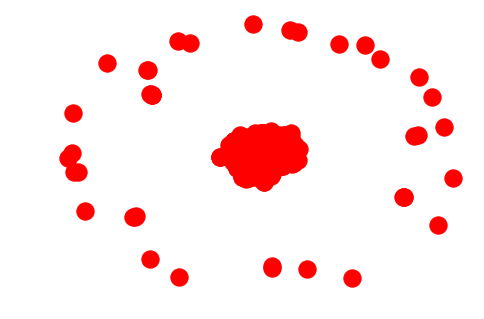

In [305]:
pos = nx.spring_layout(G)
nx.draw(G, pos) #, with_labels=True, font_weight='bold')
#edge_labels=dict([((u, v,), d['label']) for u, v, d in G.edges(data=True)])
#nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)
#nx.draw

layoutname="rt_circular"
g = G
layout = g.layout(layoutname)
bbox = [0.5*x for x in (1000,1000)]

    fname = "plots/{0}/network_Len{1}_{2}.png".format(device, prec, layoutname)
    igplot = ig.plot(g, bbox=bbox, background="white", **visual_style) #, layout = layout)
    print("   ---> Saving {0}".format(fname))
    igplot.save(fname)

In [267]:
G.edges

EdgeView([('Tobias Engel', 'Sunnyi Melles'), ('Tobias Engel', 'Heinz Trixner'), ('Tobias Engel', 'Romuald Pekny'), ('Sunnyi Melles', 'Heinz Trixner'), ('Sunnyi Melles', 'Romuald Pekny'), ('Heinz Trixner', 'Romuald Pekny')])

,Movie,Actor
0,The Last Command [1929],Emil Jannings
1,The Way of All Flesh [1929],Emil Jannings
2,The Patriot [1930],Emil Jannings
3,The Last Command [1929],Evelyn Brent
4,Underworld [1929],Evelyn Brent
5,The Last Command [1929],William Powell
6,One Way Passage [1934],William Powell
7,The Thin Man [1935],William Powell
8,Manhattan Melodrama [1935],William Powell
9,My Man Godfrey [1937],William Powell


In [145]:
actorstitles = title_principles.merge(names, on=['nconst'], how='left')
actorsmovies = actorstitles.merge(movies, on=['tconst'], how='left')

In [147]:
actorsmovies.head()

,tconst,ordering,nconst,category,job,characters,primaryName,primaryTitle,startYear
0,tt0000001,1,nm1588970,self,\N,"[""Herself""]",Carmencita,NaN,NaN
1,tt0000005,1,nm0443482,actor,\N,"[""Blacksmith""]",Charles Kayser,NaN,NaN
2,tt0000005,2,nm0653042,actor,\N,"[""Assistant""]",John Ott,NaN,NaN
3,tt0000007,1,nm0179163,actor,\N,\N,James J. Corbett,NaN,NaN
4,tt0000007,2,nm0183947,actor,\N,\N,Peter Courtney,NaN,NaN


In [52]:
namestitles['key'] = namestitles[["primaryTitle", "startYear"]].apply(lambda x: "{0} [{1}]".format(x[0], x[1]), axis=1)

In [54]:
namestitles.index = namestitles['key']

In [65]:
namestitles.tail()

,tconst,ordering,nconst,category,job,characters,primaryTitle,startYear,primaryName,key
key,,,,,,,,,,
Horrid Henry Knows It All [2014],tt9916880,1,nm1483166,actor,\N,"[""Rude Ralph"",""Mischievous Mike"",""Jolly Josh""]",Horrid Henry Knows It All,2014,Aidan Cook,Horrid Henry Knows It All [2014]
Horrid Henry Knows It All [2014],tt9916880,2,nm0254176,actress,\N,"[""Moody Margaret""]",Horrid Henry Knows It All,2014,Sue Elliott-Nichols,Horrid Henry Knows It All [2014]
Horrid Henry Knows It All [2014],tt9916880,3,nm0286175,actor,\N,"[""Dad"",""Aerobic Al"",""Nasty Nicola""]",Horrid Henry Knows It All,2014,Wayne Forester,Horrid Henry Knows It All [2014]
Horrid Henry Knows It All [2014],tt9916880,4,nm1052583,actress,\N,"[""Mum"",""Tidy Ted"",""Fang""]",Horrid Henry Knows It All,2014,Tamsin Heatley,Horrid Henry Knows It All [2014]
Horrid Henry Knows It All [2014],tt9916880,9,nm2676923,actress,\N,"[""Sour Susan"",""Goody-Goody Gordon"",""Singing So...",Horrid Henry Knows It All,2014,Joanna Ruiz,Horrid Henry Knows It All [2014]


In [224]:
awards

,Movie,tconst,Year
The Last Command [tt0019071] [1929],The Last Command,tt0019071,1929
The Way of All Flesh [tt0019553] [1929],The Way of All Flesh,tt0019553,1929
The Patent Leather Kid [tt0018253] [1929],The Patent Leather Kid,tt0018253,1929
The Noose [tt0019217] [1929],The Noose,tt0019217,1929
7th Heaven [tt0018379] [1929],7th Heaven,tt0018379,1929
Street Angel [tt0019429] [1929],Street Angel,tt0019429,1929
Sunrise [tt0018455] [1929],Sunrise,tt0018455,1929
Sadie Thompson [tt0019344] [1929],Sadie Thompson,tt0019344,1929
A Ship Comes In [tt0018389] [1929],A Ship Comes In,tt0018389,1929
Tempest [tt0019451] [1929],Tempest,tt0019451,1929


In [140]:
awards = getFile("awards/films.p")

films = DataFrame([[x[:-7] for x in dict(awards).keys()], [int(x[-5:-1]) for x in dict(awards).keys()]]).T
films.columns = ["primaryTitle", "startYear"]
films.index = films[["primaryTitle", "startYear"]].apply(lambda x: "{0} [{1}]".format(x[0], x[1]), axis=1)
films['Award'] = True
print(films.shape)
films = films[films['startYear'] > 2010]
#films.drop(["primaryTitle", "startYear"], axis=1, inplace=True)
print(films.shape)
films.head()

(7211, 3)
(1386, 3)


,primaryTitle,startYear,Award
The King's Speech [2011],The King's Speech,2011,True
127 Hours [2011],127 Hours,2011,True
Black Swan [2011],Black Swan,2011,True
Inception [2011],Inception,2011,True
The Fighter [2011],The Fighter,2011,True


In [56]:
## Match

In [124]:
possibles = movies[abs(movies['startYear'] - year) <= 2]
possibles.shape

(54173, 3)

In [135]:
Series(matches)

0                            [The King's Speech [2010]]
1                                    [127 Hours [2010]]
2                                   [Black Swan [2010]]
3                                    [Inception [2010]]
4                                  [The Fighter [2010]]
5                       [The Kids Are All Right [2010]]
6                           [The Social Network [2010]]
7                                  [Toy Story 3 [2010]]
8                                    [True Grit [2010]]
9                                [Winter's Bone [2010]]
10                                    [Biutiful [2010]]
11                              [Blue Valentine [2010]]
12                                 [Rabbit Hole [2010]]
13                                    [The Town [2012]]
14                              [Animal Kingdom [2010]]
15                                [Another Year [2010]]
16                         [Alice in Wonderland [2011]]
17    [Harry Potter and the Deathly Hallows: Par

In [153]:
for year,df in films.groupby('startYear'):
    possibles = movies[abs(movies['startYear'] - year) <= 2]
    print(year,df.shape,possibles.shape)
    
    matches = df.index.map(lambda x: difflib.get_close_matches(x, possibles.index, n=1, cutoff=0.9))
    films.loc[df.index, "Match"] = Series(matches, index=df.index).apply(lambda x: None if len(x) == 0 else x[0])
    
films.head()

2011 (137, 4) (65249, 3)
2012 (153, 4) (69912, 3)
2013 (152, 4) (74379, 3)
2014 (153, 4) (78936, 3)
2015 (153, 4) (82869, 3)
2016 (166, 4) (85404, 3)
2017 (166, 4) (83941, 3)
2018 (158, 4) (71437, 3)
2019 (148, 4) (54173, 3)


,primaryTitle,startYear,Award,tconst,Match
The King's Speech [2011],The King's Speech,2011,True,The King's Speech [2010],The King's Speech [2010]
127 Hours [2011],127 Hours,2011,True,127 Hours [2010],127 Hours [2010]
Black Swan [2011],Black Swan,2011,True,Black Swan [2010],Black Swan [2010]
Inception [2011],Inception,2011,True,Inception [2010],Inception [2010]
The Fighter [2011],The Fighter,2011,True,The Fighter [2010],The Fighter [2010]


,primaryTitle,startYear,Award,Match
The King's Speech [2011],The King's Speech,2011,True,The King's Speech [2010]
127 Hours [2011],127 Hours,2011,True,127 Hours [2010]
Black Swan [2011],Black Swan,2011,True,Black Swan [2010]
Inception [2011],Inception,2011,True,Inception [2010]
The Fighter [2011],The Fighter,2011,True,The Fighter [2010]


In [157]:
movieDB = movies.copy()
movieDB.reset_index(inplace=True)
movieDB = movieDB[["index", "tconst"]]
movieDB.columns=["Match", "tconst"]

,Match,tconst
0,The Other Side of the Wind [2018],tt0069049
1,Sabse Bada Sukh [2018],tt0069204
2,Devil Fetus [2019],tt0085953
3,The Wandering Soap Opera [2017],tt0100275
4,A Thin Life [2018],tt0111414


In [173]:
tmp = movieDB.merge(films, on="Match", how='left')
matchedMovies = tmp[~tmp['Award'].isna()]
tmp = title_principles.merge(matchedMovies, on=['tconst'], how='right')
print(tmp.shape)
tmp2 = tmp.merge(names, on=['nconst'], how='left')
print(tmp2.shape)
finalDB = tmp2[["primaryName", "primaryTitle", "startYear"]]
finalDB = finalDB[~finalDB["primaryName"].isna()]
finalDB = finalDB[~finalDB["primaryTitle"].isna()]

(4280, 7)
(4280, 8)


In [176]:
finalDB[finalDB["primaryTitle"] == "The Girl on the Train"]

,primaryName,primaryTitle,startYear
4179,Samantha Womack,The Girl on the Train,2017
4180,Matt Concannon,The Girl on the Train,2017
4181,John Dougall,The Girl on the Train,2017
4182,Oliver Farnworth,The Girl on the Train,2017
4183,Phillipa Flynn,The Girl on the Train,2017
4184,Naeem Hayat,The Girl on the Train,2017
4185,Adam Jackson-Smith,The Girl on the Train,2017
4186,Lowenna Melrose,The Girl on the Train,2017
4187,Kirsty Oswald,The Girl on the Train,2017


(4280, 7)
(4280, 8)


In [170]:
tmp2

,tconst,nconst,category,Match,primaryTitle,startYear,Award,primaryName
0,tt0369610,nm0695435,actor,Jurassic World [2015],Jurassic World,2016,True,Chris Pratt
1,tt0369610,nm0397171,actress,Jurassic World [2015],Jurassic World,2016,True,Bryce Dallas Howard
2,tt0369610,nm1339223,actor,Jurassic World [2015],Jurassic World,2016,True,Ty Simpkins
3,tt0369610,nm0339460,actress,Jurassic World [2015],Jurassic World,2016,True,Judy Greer
4,tt0409847,nm0185819,actor,Cowboys & Aliens [2011],Cowboys & Aliens,2012,True,Daniel Craig
5,tt0409847,nm0000148,actor,Cowboys & Aliens [2011],Cowboys & Aliens,2012,True,Harrison Ford
6,tt0409847,nm1312575,actress,Cowboys & Aliens [2011],Cowboys & Aliens,2012,True,Olivia Wilde
7,tt0409847,nm0817844,actress,Cowboys & Aliens [2011],Cowboys & Aliens,2012,True,Abigail Spencer
8,tt0420293,nm3009232,actor,The Stanford Prison Experiment [2015],The Stanford Prison Experiment,2015,True,Ezra Miller
9,tt0420293,nm4446467,actor,The Stanford Prison Experiment [2015],The Stanford Prison Experiment,2015,True,Tye Sheridan


In [114]:
matches = films.index.map(lambda x: difflib.get_close_matches(x, movies.index, n=1, cutoff=0.9))
films["match"] = Series(matches, index=films.index).apply(lambda x: None if len(x) == 0 else x[0])

In [115]:
films

,Award,match
The King's Speech [2011],True,The King's Speech [2010]
127 Hours [2011],True,127 Hours [2010]
Black Swan [2011],True,Black Swan [2010]
Inception [2011],True,Inception [2010]
The Fighter [2011],True,The Fighter [2010]
The Kids Are All Right [2011],True,The Kids Are All Right [2010]
The Social Network [2011],True,The Social Network [2010]
Toy Story 3 [2011],True,Toy Story 3 [2010]
True Grit [2011],True,True Grit [2010]
Winter's Bone [2011],True,Winter's Bone [2010]


In [63]:
matches = namestitles.index.map(lambda x: difflib.get_close_matches(x, films.index, n=1, cutoff=0.95))
namestitles["match"] = matches.apply(lambda x: None if len(x) == 0 else x[0])

KeyboardInterrupt: 

In [ ]:
namestitles["match"] = matches.apply(lambda x: None if len(x) == 0 else x[0])

In [45]:
awardsFilms = films.sort_values(by="primaryTitle")

In [49]:
namestitles.merge(awardsFilms, on=['primaryTitle'], how='inner')

,tconst,ordering,nconst,category,job,characters,primaryTitle,startYear_x,primaryName,startYear_y
0,tt0000181,1,nm0809419,actress,\N,"[""Cinderella""]",Cinderella,1898,Laura Bayley,2016
1,tt0000230,1,nm1333156,actress,\N,"[""Cinderella""]",Cinderella,1899,Mlle Barral,2016
2,tt0000230,2,nm0076933,actress,\N,"[""The Fairy Godmother""]",Cinderella,1899,Bleuette Bernon,2016
3,tt0000230,3,nm1778224,actor,\N,"[""Prince Charming""]",Cinderella,1899,Carmelli,2016
4,tt0000230,4,nm0194945,actress,\N,"[""Fairy Godmother""]",Cinderella,1899,Jehanne d'Alcy,2016
5,tt0000230,7,nm1778292,actor,\N,"[""Party Guest""]",Cinderella,1899,Dupeyron,2016
6,tt0001545,1,nm0478359,actress,\N,"[""Cinderella""]",Cinderella,1911,Florence La Badie,2016
7,tt0001545,2,nm0071132,actor,\N,"[""The Prince""]",Cinderella,1911,Harry Benham,2016
8,tt0001545,3,nm0741884,actress,\N,\N,Cinderella,1911,Anna Rosemond,2016
9,tt0001545,4,nm0186345,actor,\N,\N,Cinderella,1911,Frank Hall Crane,2016


In [ ]:
https://fred.stlouisfed.org/graph/fredgraph.csv?id=ILCONSTNQGSP

In [66]:
states = {
        'AK': 'Alaska',
        'AL': 'Alabama',
        'AR': 'Arkansas',
        'AS': 'American Samoa',
        'AZ': 'Arizona',
        'CA': 'California',
        'CO': 'Colorado',
        'CT': 'Connecticut',
        'DC': 'District of Columbia',
        'DE': 'Delaware',
        'FL': 'Florida',
        'GA': 'Georgia',
        'GU': 'Guam',
        'HI': 'Hawaii',
        'IA': 'Iowa',
        'ID': 'Idaho',
        'IL': 'Illinois',
        'IN': 'Indiana',
        'KS': 'Kansas',
        'KY': 'Kentucky',
        'LA': 'Louisiana',
        'MA': 'Massachusetts',
        'MD': 'Maryland',
        'ME': 'Maine',
        'MI': 'Michigan',
        'MN': 'Minnesota',
        'MO': 'Missouri',
        'MP': 'Northern Mariana Islands',
        'MS': 'Mississippi',
        'MT': 'Montana',
        'NA': 'National',
        'NC': 'North Carolina',
        'ND': 'North Dakota',
        'NE': 'Nebraska',
        'NH': 'New Hampshire',
        'NJ': 'New Jersey',
        'NM': 'New Mexico',
        'NV': 'Nevada',
        'NY': 'New York',
        'OH': 'Ohio',
        'OK': 'Oklahoma',
        'OR': 'Oregon',
        'PA': 'Pennsylvania',
        'PR': 'Puerto Rico',
        'RI': 'Rhode Island',
        'SC': 'South Carolina',
        'SD': 'South Dakota',
        'TN': 'Tennessee',
        'TX': 'Texas',
        'UT': 'Utah',
        'VA': 'Virginia',
        'VI': 'Virgin Islands',
        'VT': 'Vermont',
        'WA': 'Washington',
        'WI': 'Wisconsin',
        'WV': 'West Virginia',
        'WY': 'Wyoming'
}

In [67]:
from webUtils import getWebData

In [68]:
getWebData

<function webUtils.getWebData(base=None, suburl=None, extra=None, savename=None, dtime=5, useSafari=True, debug=False)>

In [75]:
from time import sleep
for abbr,state in states.items():
    url="https://fred.stlouisfed.org/graph/fredgraph.csv?id={0}CONSTNQGSP".format(abbr)
    savename = "fred/{0}CONSTNQGSP.p".format(abbr)
    try:
        print(state,savename)
        getWebData(base=url, savename=savename, useSafari=False)
        sleep(2)
    except:
        print("Error with {0}".format(state))

Alaska fred/AKCONSTNQGSP.p
  --> This file is 398B.
Alabama fred/ALCONSTNQGSP.p
  --> This file is 416B.
Arkansas fred/ARCONSTNQGSP.p
  --> This file is 396B.
American Samoa fred/ASCONSTNQGSP.p
Error with American Samoa
Arizona fred/AZCONSTNQGSP.p
  --> This file is 438B.
California fred/CACONSTNQGSP.p
  --> This file is 458B.
Colorado fred/COCONSTNQGSP.p
  --> This file is 432B.
Connecticut fred/CTCONSTNQGSP.p
  --> This file is 414B.
District of Columbia fred/DCCONSTNQGSP.p
  --> This file is 359B.
Delaware fred/DECONSTNQGSP.p
  --> This file is 385B.
Florida fred/FLCONSTNQGSP.p
  --> This file is 454B.
Georgia fred/GACONSTNQGSP.p
  --> This file is 436B.
Guam fred/GUCONSTNQGSP.p
Error with Guam
Hawaii fred/HICONSTNQGSP.p
  --> This file is 417B.
Iowa fred/IACONSTNQGSP.p
  --> This file is 412B.
Idaho fred/IDCONSTNQGSP.p
  --> This file is 416B.
Illinois fred/ILCONSTNQGSP.p
  --> This file is 441B.
Indiana fred/INCONSTNQGSP.p
  --> This file is 431B.
Kansas fred/KSCONSTNQGSP.p
  --> 

In [73]:
data = getFile("fred/AKCONSTNQGSP.p")

In [74]:
data

b'DATE,AKCONSTNQGSP\n2005-01-01,1979.2\n2005-04-01,2055.0\n2005-07-01,2093.2\n2005-10-01,2026.5\n2006-01-01,2052.4\n2006-04-01,2061.2\n2006-07-01,1975.5\n2006-10-01,2064.4\n2007-01-01,2080.6\n2007-04-01,2134.2\n2007-07-01,2114.1\n2007-10-01,2173.3\n2008-01-01,2102.2\n2008-04-01,2047.5\n2008-07-01,2071.2\n2008-10-01,2073.3\n2009-01-01,2154.7\n2009-04-01,2192.7\n2009-07-01,2164.0\n2009-10-01,2192.8\n2010-01-01,2095.2\n2010-04-01,2127.3\n2010-07-01,2142.0\n2010-10-01,2171.9\n2011-01-01,1964.8\n2011-04-01,2044.6\n2011-07-01,2080.0\n2011-10-01,2089.6\n2012-01-01,2026.7\n2012-04-01,2045.4\n2012-07-01,2000.0\n2012-10-01,1956.1\n2013-01-01,1845.4\n2013-04-01,1820.8\n2013-07-01,1955.0\n2013-10-01,2003.0\n2014-01-01,2071.5\n2014-04-01,2011.6\n2014-07-01,1974.8\n2014-10-01,1998.1\n2015-01-01,2189.2\n2015-04-01,2175.8\n2015-07-01,2078.3\n2015-10-01,2085.3\n2016-01-01,2012.7\n2016-04-01,1988.9\n2016-07-01,1977.3\n2016-10-01,1909.6\n2017-01-01,1835.7\n2017-04-01,1843.7\n2017-07-01,1842.5\n2017-10-01

In [76]:
from glob import glob
files = glob("fred/*.p")

In [95]:
from fileUtils import getBaseFilename
dfs = []
for ifile in files:
    data = getFile(ifile).decode("utf-8")
    f = getBaseFilename(ifile)
    
    df = DataFrame([x.split(",") for x in data.split("\n")])
    df.index = df[0]
    df.drop([0], axis=1, inplace=True)
    state = states[f[:2]]
    df.columns = [state]
    df = df[1:]
    dfs.append(df)

In [98]:
from pandas import concat
rdf = concat(dfs, axis=1)[1:]
rdf

/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


,Ohio,Washington,Pennsylvania,South Carolina,North Dakota,Idaho,Missouri,New Mexico,Arizona,Connecticut,...,Maryland,New York,Alaska,Delaware,Louisiana,New Jersey,Massachusetts,Wyoming,South Dakota,North Carolina
2005-01-01,18943.0,13656.8,21245.1,8953.0,1096.9,2880.4,10667.1,3482.8,16547.0,7190.8,...,15016.2,32789.0,1979.2,NaN,7982.2,18272.8,14486.5,1341.8,1287.3,17177.2
2005-04-01,19088.6,14036.0,21624.6,8977.5,1102.6,3087.8,11073.4,3558.0,17840.0,7409.0,...,15178.9,32531.6,2055.0,NaN,8211.1,18697.2,14830.8,1378.4,1320.4,17864.4
2005-07-01,19206.6,14676.7,21931.0,9193.0,1135.5,3194.4,11051.5,3798.4,19101.3,7536.8,...,15570.8,33123.1,2093.2,NaN,8045.4,19194.2,15258.2,1447.8,1363.8,18599.4
2005-10-01,18885.4,15166.2,21934.8,9278.6,1127.4,3338.8,11159.2,3867.0,19660.5,7704.3,...,15726.1,32776.7,2026.5,NaN,8743.5,18810.2,15243.1,1465.2,1358.4,18617.9
2006-01-01,19466.9,15531.1,23434.8,9665.2,1197.1,3675.1,11538.3,4063.2,21674.5,7954.2,...,16251.2,34115.1,2052.4,2602.2,9655.4,20113.8,15609.8,1614.9,1411.9,19611.2
2006-04-01,18886.0,15908.4,22975.4,9820.7,1237.6,3741.1,11417.0,4101.2,21341.9,7971.4,...,16119.5,34420.6,2061.2,2524.8,10222.1,20003.7,15297.7,1701.6,1436.6,19727.7
2006-07-01,18347.6,16367.8,22890.7,9810.8,1162.7,3685.1,11211.9,4094.7,21487.6,7952.4,...,15887.6,34278.1,1975.5,2488.4,10024.9,19283.8,14891.5,1716.4,1402.2,19576.0
2006-10-01,18138.4,16882.6,23107.6,9927.6,1175.3,3707.6,11126.2,4200.1,21921.0,8108.8,...,16081.7,35322.8,2064.4,2385.2,10443.3,19242.8,14780.5,1812.9,1398.8,20239.8
2007-01-01,18435.5,17865.4,23540.9,10115.4,1241.0,4030.5,11467.7,4252.0,22580.2,8197.8,...,16337.0,37003.8,2080.6,2376.0,10902.6,19479.8,15080.9,1926.8,1422.0,20969.3
2007-04-01,18857.3,18747.5,23791.4,10305.1,1221.9,4062.5,11771.4,4373.9,22360.3,8396.1,...,16416.9,38077.3,2134.2,2314.1,11114.7,20042.3,15316.9,1976.2,1467.7,21193.4


In [99]:
rdf.index.name = "Quarter"

In [102]:
rdf.to_excel("real_gdp_construction_by_state.xls")

In [113]:
from uszipcode import SearchEngine
search = SearchEngine(simple_zipcode=False)

Start downloading data for rich info zipcode database, total size 450+MB ...
  10 MB finished ...
  20 MB finished ...
  30 MB finished ...
  40 MB finished ...
  50 MB finished ...
  60 MB finished ...
  70 MB finished ...
  80 MB finished ...
  90 MB finished ...
  100 MB finished ...
  110 MB finished ...
  120 MB finished ...
  130 MB finished ...
  140 MB finished ...
  150 MB finished ...
  160 MB finished ...
  170 MB finished ...
  180 MB finished ...
  190 MB finished ...
  200 MB finished ...
  210 MB finished ...
  220 MB finished ...
  230 MB finished ...
  240 MB finished ...
  250 MB finished ...
  260 MB finished ...
  270 MB finished ...
  280 MB finished ...
  290 MB finished ...
  300 MB finished ...
  310 MB finished ...
  320 MB finished ...
  330 MB finished ...
  340 MB finished ...
  350 MB finished ...
  360 MB finished ...
  370 MB finished ...
  380 MB finished ...
  390 MB finished ...
  400 MB finished ...
  410 MB finished ...
  420 MB finished ...
  430 MB

In [109]:
data = read_csv("/Users/tgadfort/Downloads/free-zipcode-database-Primary.csv", dtype=str)

In [130]:
datas = {}
for zipcode in data['Zipcode']:
    zipdata = search.by_zipcode(zipcode)
    print(zipcode)
    datas[zipcode] = zipdata

00705
00610
00611
00612
00601
00631
00602
00603
00604
00605
00703
00704
07675
07677
07885
07981
07999
08888
08889
07095
07481
10451
10452
10453
10454
10455
10456
10457
10458
10459
10460
10461
10462
10463
10464
10465
10466
10467
10468
10469
10470
10471
10472
10473
10474
10475
10499
10001
10002
10003
10004
10005
10006
10007
10008
10009
10010
10011
10012
10013
10014
10016
10017
10018
10019
10020
10021
10022
10023
10024
10025
10026
10027
10028
10029
10030
10031
10032
10033
10034
00613
00614
00714
00616
00617
00794
00622
00623
00627
00729
00979
00981
00982
00983
00984
00985
00986
00987
00988
00736
00739
00769
00782
00783
09848
10200
09323
00659
00660
00791
00792
00662
00664
00795
00777
00728
00725
00726
00727
00737
00735
00742
00638
00780
00775
00646
00647
00738
00650
00652
00653
00784
00785
00656
00965
00966
00968
00969
00970
00971
00778
00667
00786
00669
00670
00771
00931
00933
00934
00935
00936
00772
00773
00674
00606
00707
00636
00680
00681
00682
00715
00676
00687
00718
00719
00720
0072

03774
03073
03259
03590
03260
03261
03262
03293
03290
03777
03864
03076
03458
03779
03780
03592
03263
03781
03865
03264
03801
03802
03803
03804
03805
03077
03461
03839
03866
03867
03868
03869
03266
03274
03870
03871
03079
03268
03269
03872
03873
03874
03875
03878
03882
03082
03273
03883
03462
03815
03884
03885
03782
03275
03886
03897
03084
03276
03298
03299
03465
03575
03589
03595
03887
03604
03608
03609
03278
03279
03280
03281
03282
03466
03467
03291
03890
03468
03284
03597
03469
03598
03287
03086
03470
03087
03289
03816
03894
03896
03785
05820
05440
05250
05030
05441
05031
05821
05641
05822
05839
05875
05823
05902
05101
05730
05201
05032
05732
05340
05033
05733
05301
05302
05303
05304
05034
05035
05734
05443
05036
05037
05401
05402
05403
05404
05405
05406
05407
05408
05647
05648
05444
05141
05901
05903
05735
05142
05445
05038
05143
05144
05737
05439
05446
05449
05824
05039
05825
05826
05827
05738
05739
05828
05829
05830
05251
05252
05649
05832
05640
05650
05833
05040
05076
05253
0534

07865
07064
07979
08868
07065
07066
07067
07446
08869
08870
07657
07660
07450
07451
07452
07456
07457
07661
07662
07663
07866
07068
07070
07071
07072
07073
07074
07075
07458
08871
08872
07870
07076
07094
07096
07077
07078
08873
08875
08890
08876
08879
08880
07079
07080
08882
07871
08884
07081
07874
08885
08886
07875
07980
07460
07876
07901
07902
07461
07877
07878
07666
07670
08887
07082
07879
07083
07086
07087
07088
07462
07880
07463
07881
07465
07882
07470
07474
07090
07091
07092
07480
07093
10035
10036
10037
10038
10039
10040
10041
10043
10044
10045
10055
10060
10065
10069
10075
10080
10081
10087
10090
10095
10101
10102
10103
10104
10105
10106
10107
10108
10109
10110
10111
10112
10113
10114
10115
10116
10117
10118
10119
10120
10121
10122
10123
10124
10125
10126
10128
10129
10130
10131
10132
10133
10138
10150
10151
10152
10153
10154
10155
10156
10157
10158
10159
10160
10161
10162
10163
10164
10165
10166
10167
10168
10169
10170
10171
10172
10173
10174
10175
10176
10177
10178
10179
1018

12852
12879
13413
13121
12125
13416
12964
13666
13122
13417
13812
12965
13813
12130
13667
12966
13123
12131
12132
12853
12854
12133
12855
12949
12967
13814
13124
12856
12134
13815
13668
13669
12136
13420
13472
12857
13421
13820
13424
13425
13426
13126
13825
13827
12969
13830
13428
13107
13131
13672
12137
12970
13132
12972
13134
12138
13673
13135
12973
13674
12139
13136
13137
12901
12903
13832
12140
13431
13138
13139
13140
13833
12859
12974
12975
13834
13433
13676
13699
12860
13141
13435
13142
12861
13677
12141
12976
13436
12143
12977
13678
13143
13437
12978
13679
13438
12144
13680
12147
12148
13333
13439
13784
13835
13144
12149
13681
12862
12863
13682
13440
13441
13442
13449
13683
12150
12151
12979
13684
12864
13685
13452
12980
12865
13454
12153
13145
13455
12981
12983
12866
13456
13146
12154
12008
12301
12302
12303
12304
12305
12306
12307
12308
12309
12325
12345
12155
12156
12157
12870
12985
13457
12871
13147
12158
13148
12872
13459
13460
13461
12873
13838
13839
12874
13152
13119
1315

16222
16633
15733
15626
15429
16727
15627
15430
15327
15929
16223
15734
15628
15033
15034
16834
15832
15801
16634
16729
15431
16635
15432
15930
15110
16636
16028
16029
16637
15035
15433
15112
16730
16411
15629
16030
15931
16412
16444
16116
15330
15434
15736
16731
16413
15037
15331
16117
15737
15038
15934
15738
16373
15834
16321
16322
16120
16501
16502
16503
16504
16505
16506
16507
16508
16509
16510
16511
16512
16514
16515
16522
16530
16531
16534
16538
16541
16544
16546
16550
16553
16563
16565
16033
15537
15631
15632
15435
15436
15538
16224
16415
16639
15840
15437
16121
15438
16034
15332
16225
15539
16835
16640
16123
15633
15841
16226
16228
16035
15540
16036
16323
15333
16124
15042
16229
16836
16850
15541
15549
16326
16641
15334
16416
15542
15336
15043
15440
15044
16732
15741
16417
16644
15045
15742
15116
15046
16838
16420
15634
15544
15337
15047
15338
15601
15605
15606
16125
15442
16127
16327
16130
15744
15635
16421
16422
16037
15636
16038
16131
15049
16646
16675
16840
16230
16733
1574

17081
17246
18651
18347
18348
18349
18350
18346
17965
19549
18351
17082
17864
17865
17901
17974
18454
18455
18456
18245
17566
17247
17355
17763
18653
17966
19601
19602
19603
19604
19605
19606
19607
19608
19609
19610
19611
19612
17567
17867
18073
18076
17356
18352
17084
17568
19550
17569
17764
17085
17570
17086
17087
18077
17967
17868
17765
19551
18246
17249
18837
17572
17358
17250
18457
17251
16943
17968
17970
18247
17252
17253
18353
18840
17088
18078
17972
18354
17254
18355
18501
18502
18503
18504
18505
18507
18508
18509
18510
18512
18515
18517
18518
18519
18540
18577
17870
17360
17255
17256
17866
17872
17876
19554
18654
18356
17976
18248
17090
18655
17257
17260
19555
18458
17361
17768
17575
18357
18079
17769
18080
17576
18459
18842
18843
17261
18460
17978
17354
17362
17262
18081
18844
18461
18462
17263
18463
17578
18845
17363
18083
17579
19559
18360
18249
18846
17093
18250
17979
18084
17801
17877
18847
18656
17880
18370
18251
16945
18464
17580
18252
18372
18085
19560
17581
17364
1846

25121
25860
25862
24714
24733
25535
25864
25251
26676
25676
25123
25971
25252
25537
25972
25865
25253
24901
24902
25124
24951
26384
26629
26581
25125
25866
25601
25612
25654
25126
25868
25259
25630
26229
26810
26385
26386
25632
24857
25875
25876
26278
25871
25873
26138
26148
26152
25130
26541
25634
25132
25635
26582
24954
25401
25402
25403
25404
25405
25260
26542
25678
24860
26812
24736
24957
24861
25133
26833
25966
25976
26404
25977
26585
25134
26149
25540
25878
26280
25261
25432
25262
25541
25879
26120
26121
26150
26405
26586
24737
25136
26283
26836
26838
26501
26502
26504
26505
26506
26507
26508
25139
26408
25637
25880
26678
26679
26684
26739
26151
25870
25882
26680
25140
26631
25685
25141
25009
25142
24738
24751
26681
26374
26410
26743
24866
25265
26155
26162
26411
24867
25266
25686
25978
25143
25267
24868
25688
26285
25901
24854
24870
25902
26845
25638
25545
26886
25148
26412
25268
26543
25149
26159
24871
26160
24846
24862
24872
26101
26102
26103
26104
26105
26106
26287
25431
2543

40403
40404
42516
40007
41605
40913
41606
42712
40914
40405
40808
40915
41804
41832
41124
41160
41226
40810
40816
40008
41607
42027
42713
41719
41314
41351
41364
41204
40107
42101
42102
42103
42104
42128
40009
40108
42715
42741
42325
40409
42518
40109
42210
40921
40410
41721
40010
42716
41722
41517
40310
42717
42028
42519
42211
42327
42371
42029
40813
40011
40075
42718
42719
42733
40376
41301
41360
41519
42720
42721
42722
41408
40923
40311
40350
41725
41128
41129
42127
40815
42724
42214
42328
42330
42215
40012
41727
42726
42404
40312
41317
40313
42332
40110
42216
42031
40927
40111
40819
42728
42753
42032
41729
40701
40702
41731
41819
42406
40013
40419
40820
42033
40014
41413
42217
41810
42333
42729
40823
42035
40115
41615
40422
40423
40452
41616
42408
40824
41812
41735
40316
40930
42036
41736
42409
41520
42321
42326
42337
42731
42219
42338
42339
42528
41621
41739
42037
42410
40729
41622
42732
40018
42038
42129
40117
42701
42702
41522
41542
42220
42280
40317
40019
40730
41740
40826
4181

43458
44455
44085
44272
43462
45883
45884
45885
44460
43945
44870
44871
44671
43946
44874
43988
45886
44672
44273
43947
44274
44875
44675
43556
44878
44676
43948
44677
44678
44470
44275
45887
43950
44276
43952
43953
43463
44680
43961
44471
43519
43557
44681
44880
44856
44881
43962
43558
44882
43560
44278
44086
44845
44883
43963
44887
43460
43601
43603
43604
43605
43606
43607
43608
43609
43610
43611
43612
43613
43614
43615
43616
43617
43619
43620
43623
43635
43652
43654
43656
43657
43659
43660
43661
43666
43667
43681
43682
43697
43699
43565
43964
44682
44087
44679
44683
44699
44685
44088
45888
44280
45889
45890
45891
45893
45894
44089
43464
44473
44281
44282
44889
43465
44687
45819
45895
43967
44481
44482
44483
44484
44485
44486
44488
44490
43566
43567
44285
43466
44688
45896
44090
43968
44491
44251
43467
43569
44287
43570
43571
44092
44888
44890
44093
43468
44094
44095
44096
44097
45898
44689
44288
44099
44690
44493
43970
43469
44691
45899
43971
44501
44502
44503
44504
44505
44506
4450

52557
52046
52047
52626
50538
52142
50539
50078
50434
52560
50435
50540
50846
50436
52144
50501
50569
52627
51340
50630
50631
52561
52749
50101
51020
50102
50103
52049
50438
52229
50632
50633
51237
50104
50105
50634
51341
50106
50541
50635
51443
50542
50439
52727
52750
50543
51342
50440
50107
52751
50108
52752
50109
50847
51022
50848
50110
52050
50636
50849
50111
50112
50638
50657
50115
52048
52052
51432
51444
50116
50441
50444
50544
50545
52146
51345
50118
50252
51346
50119
50546
50120
51011
51023
52147
52562
50641
52563
52233
52235
52630
51024
50642
51025
52053
52066
52236
52237
51015
51026
51238
52631
50122
50643
51239
50548
50123
50124
51445
50644
50125
51240
50645
52240
52241
52242
52243
52244
52245
52246
50126
51027
51446
51447
50128
50647
50059
50129
50648
50130
50131
50446
50551
52247
50132
50447
50133
50134
50135
50448
52632
52565
52231
52248
50136
52249
50137
51028
52566
51448
50449
50552
50138
50139
52251
51449
50450
51347
51450
50451
50140
50650
52054
51451
52151
50651
5124

55082
55083
56174
55783
56289
56382
55786
55787
55977
56291
55084
56683
55615
55790
56132
56175
56684
56176
56088
56089
55616
56178
56384
55979
55085
56481
56090
56287
56292
55386
56385
55777
55792
55968
55981
56293
55387
56482
56386
56091
56430
56436
56484
56180
55982
55983
56294
55742
55752
55784
55793
55087
56093
56685
55388
56096
55389
56295
55390
55361
55391
55392
55088
55089
56181
56097
56183
55985
56296
55090
56686
56201
55795
56185
56101
56118
56140
56047
56098
55942
55987
55988
55395
55396
56297
56186
56187
55749
55797
55798
55990
55092
55368
55383
55394
55397
55399
55550
55551
55552
55553
55554
55555
55556
55557
55558
55559
55560
55562
55564
55566
55567
55568
55573
55583
55594
55398
55991
55992
54610
54611
54805
54720
54001
54612
54721
54613
54806
54722
54002
54810
54614
54812
54813
54723
54814
54003
54817
54834
54857
54615
54616
54724
54725
54726
54819
54820
54821
54727
54822
54618
54637
54619
54824
54621
54728
54729
54774
54004
54005
54622
54730
54826
54731
54623
54732
5482

57342
57442
57455
57631
57238
57529
57533
57239
57439
57445
57534
57032
57536
57033
57241
57242
57446
57243
57744
57632
57538
57571
57345
57346
57540
57745
57348
57448
57747
57450
57349
57748
57034
57035
57036
57350
57399
57541
57451
57037
57353
57633
57452
57038
57543
57354
57544
57751
57355
57245
57752
57356
57247
57248
57233
57249
57454
57636
57754
57638
57039
57456
57040
57359
57639
57457
57548
57041
57641
57642
57042
57756
57460
57043
57047
57547
57551
57574
57251
57644
57461
57045
57552
57246
57252
57253
57553
57362
57555
57046
57301
57601
57659
57048
57634
57645
57660
57646
57363
57640
57559
57759
57255
57758
57760
57364
57761
57762
57560
57049
57465
57050
57057
57365
57763
57782
57764
57562
57563
57051
57052
57466
57564
57766
57467
57053
57366
57566
57257
57567
57367
57769
57468
57501
57770
57368
57369
57648
57772
57568
57773
57370
57775
57054
57701
57702
57703
57709
57258
57469
57776
57371
57569
57651
57259
57652
57470
57471
57570
57260
57261
57572
57373
57779
57058
57780
5705

67846
67868
67050
67529
67638
67444
67051
67445
67446
67052
67053
66417
66428
67735
67640
67736
67737
66429
67530
67447
66943
67054
67346
66852
67738
67448
66944
67056
66853
66945
67849
67057
67058
66854
66431
67347
67543
67059
67601
67660
67667
67060
67850
67449
67739
67062
66434
67642
67659
67063
67544
67851
66946
66436
67450
66438
67451
66439
67349
67740
66440
67545
67951
67452
67501
67502
67504
67505
67301
67853
67546
67065
67066
66948
67635
67643
67854
66949
67855
66441
66442
67454
67741
67067
67857
66951
67068
67547
67061
67070
67644
67859
67548
67553
67860
67550
67072
66952
66856
67073
67629
67645
67074
66449
67861
66857
67552
67901
67905
67351
67455
66858
67456
66953
67457
67646
67458
67647
67352
67459
66859
67648
67649
66451
67554
67556
67745
67460
67557
66855
66860
66955
67101
66502
66503
66505
66506
66956
67862
66507
67863
66861
67464
66508
66509
67103
67864
67071
67104
66510
66512
67105
66514
67106
67118
67466
67467
67865
67353
67867
67468
67650
66515
66958
67952
67107
6735

80444
80623
80624
80532
81601
81602
80401
80402
80403
80419
81041
80446
81501
81502
81503
81504
81505
81506
81507
81523
80447
80631
80632
80633
80634
80638
80639
80819
80729
80820
81230
81231
81247
81637
81638
81043
80449
81044
81045
80731
81639
80640
80732
81326
80733
81046
81047
80734
81136
81419
80451
81233
80642
80821
80533
80452
80735
80453
81137
80736
80454
80455
81138
80822
80534
80737
80823
80643
80644
81049
80117
80824
80825
80457
80459
80026
81140
81050
81235
80827
81052
80535
80118
80645
81038
81054
81055
81420
80429
80461
81327
80826
80828
80740
80120
80121
80122
80123
80124
80125
80126
80127
80128
80129
80130
80160
80161
80162
80163
80165
80166
80536
81524
80501
80502
80503
80504
80027
80131
80537
80538
80539
80646
80540
81057
80463
81525
81141
81328
80829
81058
81329
80541
80830
81640
80542
81641
81642
80741
81643
81330
80543
81645
81059
81143
81646
81135
81144
81401
81402
81403
80132
80465
81146
81236
81422
80466
81647
80742
80544
81423
81424
80648
80467
81425
81062
8142

85140
85142
85143
85145
85654
86335
86342
85545
85121
85147
85546
85548
85629
85630
85936
86511
85348
85550
86512
85349
85631
85632
85633
85250
85251
85252
85253
85254
85255
85256
85257
85258
85259
85260
85261
85262
85263
85264
85266
85267
85268
85269
85271
86043
86336
86339
86340
86341
86351
86337
85634
85901
85902
85911
85912
85613
85635
85636
85650
85670
85671
86338
85937
85942
85551
85350
85611
85637
85938
85172
85351
85372
85373
85374
85375
85376
85378
85379
85387
85388
86435
85173
85333
85347
85352
85939
86514
86535
86544
85280
85281
85282
85283
85284
85285
85287
85552
85353
85638
86044
86053
86054
85354
85553
85639
86436
86045
85701
85702
85703
85704
85705
85706
85707
85708
85709
85710
85711
85712
85713
85714
85715
85716
85717
85718
85719
85720
85721
85722
85723
85724
85725
85726
85728
85730
85731
85732
85733
85734
85735
85736
85737
85738
85739
85740
85741
85742
85743
85744
85745
85746
85747
85748
85749
85750
85751
85752
85754
85755
85756
85757
85775
85640
85645
85646
85641
8519

97885
97489
97490
97761
97146
97065
97491
97067
97920
97492
97493
97068
97886
97147
97494
97396
97544
97070
97495
97416
97496
97497
97071
97498
97148
97499
98601
98602
98603
98604
98605
98606
98607
98609
98610
98611
98612
98614
98616
98617
98619
98613
98620
98622
98623
98624
98625
98626
98628
98670
98629
98631
98637
98632
98635
98638
98639
98640
98641
98642
98621
98643
98644
98647
98648
98645
98649
98650
98651
98660
98661
98662
98663
98664
98665
98666
98668
98682
98683
98684
98685
98686
98687
98671
98672
98673
98674
98675
83520
83801
83802
83803
83804
83805
83806
83808
83810
83811
83813
83814
83815
83816
83821
83522
83533
83523
83524
83548
83823
83824
83825
83826
83525
83827
83526
83812
83830
83832
83530
83531
83833
83842
83834
83835
83836
83535
83536
83837
83537
83839
83539
83841
83540
83541
83501
83542
83843
83844
83845
83846
83847
83865
83543
83848
83544
83849
83545
83546
83850
83851
83547
83840
83852
83853
83854
83877
83855
83822
83856
83857
83858
83549
83809
83860
83861
83864
8386

91012
91023
93532
93240
93241
93534
93535
93536
93539
93584
93586
93242
93243
93541
93244
93245
93246
93247
93543
93544
93436
93437
93438
93545
93440
93441
93249
93250
93251
93546
93252
93501
93502
93504
93505
93519
91016
91017
91020
91021
93020
93021
93442
93443
93254
93444
91601
91602
91603
91604
91605
91606
91607
91608
91609
91610
91611
91612
91614
91615
91616
91617
91618
91324
91325
91326
91327
91328
91329
91330
93022
93445
93475
93023
93024
93549
93255
93030
93031
93032
93033
93034
93035
93036
91331
91333
91334
93550
93551
93552
93590
93591
93599
91101
91102
91103
91104
91105
91106
91107
91108
91109
91110
91114
91115
91116
91117
91118
91121
91123
91124
91125
91126
91129
91182
91184
91185
91188
91189
91199
93446
93447
93553
93563
93040
93448
93449
93256
93257
93258
93041
93042
93043
93044
93260
91335
91337
93261
93555
93556
93560
93450
91340
91341
91342
91343
91344
91345
91346
91392
91393
91394
91395
93401
93402
93403
93405
93406
93407
93408
93409
93410
93412
93451
93452
93101
9310

93930
94548
94549
94550
94551
93932
95030
95031
95032
95033
93933
94553
95035
95036
93940
93942
93943
93944
94556
94570
94575
95037
95038
95039
95041
94558
94559
94581
95042
94560
94601
94602
94603
94604
94605
94606
94607
94608
94609
94610
94611
94612
94613
94614
94615
94617
94618
94619
94620
94621
94622
94623
94624
94649
94659
94660
94661
94662
94666
94561
94562
94563
93950
95043
93953
94564
94565
94566
94568
94588
94567
94569
95026
95044
94801
94802
94803
94804
94805
94806
94807
94808
94820
94850
94571
94547
94572
94573
94574
93901
93902
93905
93906
93907
93908
93912
93915
93962
95013
95101
95103
95106
95108
95109
95110
95111
95112
95113
95115
95116
95117
95118
95119
95120
95121
95122
95123
95124
95125
95126
95127
95128
95129
95130
95131
95132
95133
95134
95135
95136
95138
95139
95140
95141
95148
95150
95151
95152
95153
95154
95155
95156
95157
95158
95159
95160
95161
95164
95170
95172
95173
95190
95191
95192
95193
95194
95196
95045
94577
94578
94579
94580
93954
95046
94582
94583
9505

30999
30803
31624
31716
39817
39818
39819
31625
30413
31720
31513
31515
31722
31516
39823
31302
39824
30805
31004
31005
30806
31626
31801
39825
31518
39826
31727
30415
31519
31520
31521
31522
31523
31524
31525
31527
31561
31803
31006
31007
31008
31009
39827
39828
39829
30807
31730
31804
31627
39832
31011
31012
31733
30414
30417
30438
39834
31013
31303
31735
30420
31014
39836
30421
39837
31829
31901
31902
31903
31904
31905
31906
31907
31908
31909
31914
31917
31993
31995
31997
31998
31999
31738
31010
31015
31304
31016
31805
39840
30423
39841
31017
31305
31018
39842
30808
31532
31743
31019
31629
31744
39845
31533
31534
31535
30424
31020
31021
31027
31040
31022
31630
31023
31024
31026
31307
39846
31025
31308
31806
31747
31807
31749
30809
31631
31750
31309
31537
31029
39851
31808
31030
39852
31753
30425
31810
39854
30810
30426
30427
30428
31031
30812
31032
30813
31312
31033
30429
31632
31811
31034
30814
31035
31756
31036
31539
31037
30815
31038
31310
31313
31314
31315
31542
31634
31543
3103

32187
34230
34231
34232
34233
34234
34235
34236
34237
34238
34239
34240
34241
34242
34243
34276
34277
34278
32189
32775
32958
32976
32978
33870
33871
33872
33875
33876
33583
33584
32190
32959
32776
32192
33585
33586
33587
34270
33601
33602
33603
33604
33605
33606
33607
33608
33609
33610
33611
33612
33613
33614
33615
33616
33617
33618
33619
33620
33621
33622
33623
33624
33625
33626
33629
33630
33631
33633
33634
33635
33637
33646
33647
33650
33655
33660
33661
33662
33663
33664
33672
33673
33674
33675
33677
33679
33680
33681
33682
33684
33685
33686
33687
33688
33689
33694
32777
34688
34689
34690
34691
34692
32778
34250
33592
32780
32781
32783
32796
33593
32784
33594
33595
33596
34284
34285
34286
34287
34288
34289
34290
34291
34292
34293
33960
32960
32961
32962
32963
32964
32965
32966
32967
32968
32969
32970
33873
33877
33597
32195
32193
34785
33598
34786
32971
34777
34778
34787
33880
33881
33882
33883
33884
33885
33888
32789
32790
32792
32793
34797
32798
33539
33540
33541
33542
33543
3354

38659
39756
39474
39354
39151
39152
39475
39355
39153
38864
39154
38661
39156
38767
39476
39157
39158
38865
38663
38664
39159
38768
38769
39356
39661
38771
39662
39107
39160
38866
39477
39161
39478
38665
38666
39162
39574
38952
38953
39358
38772
39359
39479
38668
38868
39163
38773
38774
38869
39360
39361
39165
38954
39115
39166
39663
38628
38670
39664
38870
39665
39480
38671
38672
39167
39759
39760
39362
39766
39767
38776
39363
39460
39481
39769
39666
38957
39482
38778
38959
38673
39168
39169
39170
38871
38961
39173
38674
38962
38873
38874
39364
39174
38875
38876
38676
38801
38802
38803
38804
38963
39667
39365
39668
38677
39175
39176
39177
38964
38877
38878
38879
39180
39181
39182
39183
38679
39366
38680
38686
38683
39189
39771
39190
38685
38965
39367
38780
38966
39772
39191
39192
39754
39773
38880
39577
38967
38781
39776
39669
39194
70510
70511
70420
71316
70710
71401
70711
71301
71302
71303
71306
71307
71309
71315
70031
70340
70422
71403
70426
70467
70712
70032
71001
71218
70512
7100

72454
72669
71601
71602
71603
71611
71612
71613
72566
72857
72567
72568
72127
72455
72478
72456
72670
72374
72457
71663
72858
72569
72458
72128
72753
72129
71857
72130
72376
72672
72131
72951
72459
72460
72461
72132
72133
72462
71665
72377
72134
72756
72757
72758
72135
72136
72137
72571
71858
72828
72860
71968
72952
72139
72801
72802
72811
72812
72572
72573
72140
72464
72675
72760
72575
72515
72576
71859
72141
72142
72863
72143
72145
72149
72465
72150
72152
72088
72153
72577
72761
71969
71762
72466
72379
72156
71763
72762
72764
72765
72766
72157
71860
71667
72467
71764
71970
72469
71765
72578
72160
72865
72470
72579
72768
72769
72677
72164
72471
71861
72165
71766
72166
71670
72679
72657
72680
72770
72167
72472
72168
72473
72581
72169
72383
72384
72386
72170
71971
72955
72682
72956
72957
71972
72387
72683
72173
72583
72584
72389
72175
72474
72475
71770
72958
72476
72176
71671
71862
71674
72479
72773
72685
72774
72390
72301
72303
72178
72391
72392
71772
71973
72585
72394
72179
72482
7186

75975
75489
75490
75163
75862
75789
75701
75702
75703
75704
75705
75706
75707
75708
75709
75710
75711
75712
75713
75798
75799
75790
75495
75692
75165
75167
75168
75976
75485
75097
75791
75693
75491
75977
75169
75172
75492
75493
75494
75792
75978
75496
75865
75694
75979
75990
75098
75497
75980
73901
73931
73932
73933
73937
73938
73939
73942
73944
73945
73946
73947
73949
73950
73951
79311
79601
79602
79603
79604
79605
79606
79607
79608
79697
79698
79699
79001
79002
76430
76008
79003
76009
76225
79101
79102
79103
79104
79105
79106
79107
79108
79109
79110
79111
79114
79116
79117
79118
79119
79120
79121
79124
79159
79166
79168
79172
79174
79178
79185
79189
79312
79501
79313
76351
76226
76001
76002
76003
76004
76005
76006
76007
76010
76011
76012
76013
76014
76015
76016
76017
76018
76019
76094
76096
76820
79502
76227
76020
76098
79504
76821
76823
76930
76021
76022
76095
76228
76824
79505
76932
79506
76432
79314
76352
76433
79005
79007
79008
79009
76230
76023
76825
76424
76426
79011
76933
7682

78538
76524
78539
78540
78541
78542
77957
78352
78621
78860
78938
78112
76640
79901
79902
79903
79904
79905
79906
79907
79908
79910
79911
79912
79913
79914
79915
79916
79917
79918
79920
79922
79923
79924
79925
79926
79927
79928
79929
79930
79931
79932
79934
79935
79936
79937
79938
79940
79941
79942
79943
79944
79945
79946
79947
79948
79949
79950
79951
79952
79953
79954
79955
79958
79960
79961
79968
79976
79978
79980
79990
79995
79996
79997
79998
79999
88510
88511
88512
88513
88514
88515
88516
88517
88518
88519
88520
88521
88523
88524
88525
88526
88527
88528
88529
88530
88531
88532
88533
88534
88535
88536
88538
88539
88540
88541
88542
88543
88544
88545
88546
88547
88548
88549
88550
88553
88554
88555
88556
88557
88558
88559
88560
88561
88562
88563
88565
88566
88567
88568
88569
88570
88571
88572
88573
88574
88575
88576
88577
88578
88579
88580
88581
88582
88583
88584
88585
88586
88587
88588
88589
88590
88595
78543
78019
78353
76525
79838
78545
78355
78113
77960
78940
78622
78623
76526
7894

47982
47881
47585
46180
47983
47387
46789
47882
47388
46379
46070
46986
46987
47465
46567
47280
47586
47801
47802
47803
47804
47805
47807
47808
47809
47811
47812
46381
46071
46570
46045
46072
46571
46181
47588
47467
46988
46572
47390
46791
46382
47468
47884
46989
46990
47281
46383
46384
46385
46991
47987
47590
47282
47591
46992
46573
46182
46574
46994
46390
46792
46580
46581
46582
47501
46793
47989
46794
47990
47392
47469
46074
47991
46995
46183
47596
47992
47283
47885
46391
46380
46392
47597
46393
46184
46075
46394
46186
47470
47393
47993
46996
47394
46076
47994
46590
47598
47995
46795
46796
46797
47471
46595
47997
46798
47396
46998
46799
46077
49220
49221
49224
48001
49227
48101
48002
48003
48004
48103
48104
48105
48106
48107
48108
48109
48113
48401
48410
48005
48411
48412
48006
48413
48414
48111
48112
48415
48009
48012
49228
48301
48302
48303
48304
48114
48116
49229
49230
48416
48417
48418
49232
48014
48117
48419
49233
49281
48015
48118
49234
48346
48347
48348
48017
49235
49236
4842

61104
61105
61106
61107
61108
61109
61110
61111
61112
61114
61115
61125
61126
61130
61131
61132
61072
61073
60073
60075
61074
61075
61077
61078
61079
60076
60077
61080
60081
61081
61084
61085
60082
60083
61087
60084
60079
60085
60087
60090
60091
61088
60093
61089
60096
60097
60098
61091
60099
54405
54101
53910
53927
53001
53501
53502
54201
53002
54909
54102
54406
54407
54408
54409
54430
54911
54912
54913
54914
54915
54919
53503
54511
53504
53911
54103
54410
53003
54104
54411
54412
53505
53506
54413
53801
54202
54921
53913
53507
53101
54922
53916
53802
53004
53508
53510
53511
53512
53803
54923
53103
54926
54414
54106
53515
53516
54415
53804
53517
53518
54107
54182
53805
53827
54512
54416
53919
54513
53920
54110
53104
53520
54417
53005
53008
53045
53521
53006
53522
54204
53105
53922
53007
54927
54514
53108
53923
53523
53010
53109
54928
53011
54205
53806
54515
53924
54111
53012
53013
54420
53014
54517
53015
53525
54929
53016
53526
54421
54112
53017
54207
54930
53925
54113
54519
53527
5452

61812
61911
62612
62808
61912
62510
62613
61913
62615
62311
62344
62907
62216
62217
62312
62218
62313
62006
62617
62314
62618
62512
62219
62414
62444
62908
62810
62220
62221
62222
62223
62225
62226
62811
61813
62009
62812
62010
61914
62011
61814
62513
62621
62622
62814
62909
61815
62815
62816
62514
62316
62230
62417
62012
61816
61917
62910
62817
62624
62818
62418
62013
62819
62515
62517
62912
62014
62820
62015
62914
62419
61919
62915
62319
62916
62320
62625
62901
62902
62903
62626
62231
62821
62917
62016
62918
62321
62420
62232
61817
62919
62801
61818
62323
61820
61821
61822
61824
61825
61826
62627
62628
61920
62629
62233
62630
62518
61924
62822
61830
62823
62421
62824
62324
62325
62920
62825
62017
62326
62234
61831
62921
62236
62329
62631
62519
62018
62237
62422
62922
62827
62238
62923
62828
62829
62330
61925
61832
61833
61834
62520
62521
62522
62523
62524
62525
62526
61839
62924
61840
62424
62530
62830
62926
62019
62021
62022
62927
62831
62425
62239
62832
62023
62024
62240
62633
6220

20722
20833
20615
20616
20617
20866
20618
20818
20619
20620
20731
20743
20747
20753
20791
20799
20621
20622
20623
20732
20733
20871
20624
20735
20625
20740
20741
20742
20626
20627
20872
20628
20751
20842
20629
20630
20754
20632
20755
20744
20745
20749
20750
20758
20759
20877
20878
20879
20882
20883
20884
20885
20886
20898
20899
20765
20896
20874
20875
20876
20812
20769
20634
20768
20770
20771
20776
20635
20777
20636
20637
20639
20781
20782
20783
20784
20785
20787
20788
20640
20643
20645
20794
20891
20895
20703
20706
20646
20707
20708
20709
20723
20724
20725
20726
20650
20653
20711
20656
20657
20658
20659
20660
20712
20661
20662
20664
20682
20714
20830
20832
20736
20667
20670
20674
20675
20837
20676
20677
20678
20697
20790
20797
20680
20737
20738
20847
20848
20849
20850
20851
20852
20853
20854
20855
20857
20859
20684
20685
20686
20860
20763
20687
20764
20901
20902
20903
20904
20905
20906
20907
20908
20910
20911
20912
20913
20914
20915
20916
20918
20993
20997
20688
20868
20897
20689
2069

28575
28773
28774
28775
28577
28581
28578
28459
28467
28468
28469
23176
23888
23177
23178
23889
24484
22572
23890
23891
22980
22576
24485
22577
23091
23181
24486
22987
23183
23893
22578
23184
22579
23081
23185
23186
23187
23188
24487
23486
23894
23487
23488
22580
23190
23976
23897
23690
23691
23692
23693
23898
27006
27910
27201
27202
27501
27502
27523
27539
27007
27203
27204
27205
27805
27806
27915
27916
27503
27807
28604
28691
27917
27808
27809
27207
27009
27810
27811
27919
27208
27504
27010
27812
27209
27813
27814
28605
27213
28606
28607
28608
27011
27505
27214
27506
27507
27508
27215
27216
27217
27509
27920
27921
27229
27510
27511
27512
27513
27518
27519
27816
28609
27230
27231
27514
27515
27516
27517
27599
27817
28610
27520
27527
27528
27012
27013
27233
27521
27922
27923
27924
27235
28611
27925
27818
27819
28612
28613
27820
27014
27926
27927
27522
28615
27928
28616
28617
27929
27016
28618
27239
27017
28619
27701
27702
27703
27704
27705
27706
27707
27708
27709
27710
27711
27712
2771

29453
29065
29351
29455
29457
29555
29353
29395
29067
29355
29556
29456
29656
29560
29563
29069
29356
29564
29565
29360
29006
29070
29071
29072
29073
29657
29074
29075
29566
29567
29364
29082
29658
29568
29569
29659
29078
29079
29365
29080
29101
29458
29570
29102
29661
29571
29662
29104
29368
29573
29430
29461
29105
29369
29664
29464
29465
29466
29370
29574
29576
29572
29575
29577
29578
29579
29587
29588
29107
29580
29108
29665
29111
29581
29666
29667
29112
29582
29597
29598
29113
29114
29115
29116
29117
29118
29372
29373
29583
29584
29374
29585
29122
29123
29669
29670
29671
29673
29468
29125
29469
29126
29127
29589
29470
29471
29375
29128
29675
29129
29472
29130
29132
29376
29474
29133
29475
29476
29477
29135
29479
29676
29137
29590
29138
29677
29142
29591
29592
29672
29678
29679
29145
29680
29681
29682
29683
29481
29593
29301
29302
29303
29304
29305
29306
29307
29316
29318
29319
29146
29684
29377
29147
29482
29148
29483
29484
29485
29150
29151
29152
29153
29154
29685
29160
29686
2959

35225
35230
35240
35245
35263
35277
35278
35279
35280
35281
35286
35289
35299
36210
37990
38110
38142
38165
38227
39235
40386
40495
40754
40931
40999
41313
41433
42283
42287
42375
42403
43098
43163
43196
43198
43265
43299
43307
43618
43789
44178
44185
44189
44322
44393
44399
44631
44999
45228
45400
45408
45427
45463
46604
46620
47430
47490
47727
47739
47741
47744
47856
47864
48559
48736
48769
48802
48863
49069
49121
49550
49790
50347
50397
50706
51344
52319
52350
52538
53199
53244
55161
55169
55177
55191
55468
55561
55563
57056
57079
57188
57189
60679
62224
62713
62746
62805
62857
63001
63190
63196
63198
64172
64183
64185
64192
64193
64194
64447
64789
64944
66077
66279
66637
66642
66652
66653
66692
68181
70140
70149
70500
70595
70883
71208
71768
71844
71951
72189
72198
72439
73094
73193
73197
73198
73199
73451
73454
74183
74184
74189
74194
74542
75037
75245
75258
75286
75310
75323
75334
75340
75343
75344
75353
75363
75364
75386
75387
77869
78262
78275
78286
78461
78470
78471
78473
7847

42522

In [131]:
zipcodeData = {}
for k,v in datas.items():
    v2 = v.to_dict()
    print(v2["major_city"])
    zipcodeData[k] = {k2: v2[k2] for k2 in ["major_city", "county", "state", "population_density", "median_household_income"]}

Aibonito
Anasco
Angeles
Arecibo
Adjuntas
Castaner
Aguada
Aguadilla
Aguadilla
Aguadilla
Aguas Buenas
Aguirre
Westwood
Woodcliff Lake
Wharton
Whippany
Whippany
Whitehouse
Whitehouse Station
Woodbridge
Wyckoff
Bronx
Bronx
Bronx
Bronx
Bronx
Bronx
Bronx
Bronx
Bronx
Bronx
Bronx
Bronx
Bronx
Bronx
Bronx
Bronx
Bronx
Bronx
Bronx
Bronx
Bronx
Bronx
Bronx
Bronx
Bronx
Bronx
New York
New York
New York
New York
New York
New York
New York
New York
New York
New York
New York
New York
New York
New York
New York
New York
New York
New York
New York
New York
New York
New York
New York
New York
New York
New York
New York
New York
New York
New York
New York
New York
New York
Arecibo
Arecibo
Arroyo
Bajadero
Barceloneta
Barranquitas
Boqueron
Cabo Rojo
Camuy
Canovanas
Carolina
Carolina
Carolina
Carolina
Carolina
Carolina
Carolina
Carolina
Carolina
Cayey
Cidra
Coamo
Comerio
Corozal
None
New York
None
Hatillo
Hormigueros
Humacao
Humacao
Isabela
Jayuya
Juana Diaz
Juncos
Ponce
Caguas
Caguas
Caguas
Cayey
Ceiba
Roosev

Machias
Wesley
Machiasport
Madawaska
Madison
Manchester
Mapleton
Mars Hill
Matinicus
Mattawamkeag
Mechanic Falls
Meddybemps
Bremen
Medway
Mexico
Milbridge
Milford
Millinocket
Milo
Minot
Monhegan
Monmouth
Monroe
Monson
Monticello
Moody
Morrill
Mount Desert
Mount Vernon
Naples
Newcastle
Newfield
New Gloucester
New Harbor
Pemaquid
Newport
Newry
New Sharon
New Sweden
New Vineyard
Nobleboro
Norridgewock
North Anson
North Berwick
North Bridgton
Northeast Harbor
Edgecomb
North Haven
North Monmouth
New Portland
New Portland
Sullivan
North Turner
North Vassalboro
North Waterboro
North Waterford
Whitefield
Windham
South Windham
Norway
Oakfield
Oakland
Ogunquit
Ocean Park
Old Orchard Beach
Old Town
Oquossoc
Orient
Orland
Orono
Orono
Orrington
Orrs Island
Owls Head
Oxbow
Oxford
Palermo
Palmyra
Paris
Passadumkeag
Patten
Pembroke
Penobscot
Perham
Perry
Phillips
Phippsburg
Pittsfield
Plymouth
Poland
Portage
Port Clyde
Porter
Portland
Portland
Portland
Portland
Falmouth
South Portland
Cape Elizabeth
P

Woodbury
Woodstock
Worcester
Amston
Andover
Ansonia
Ashford
Avon
Ballouville
Baltic
Bantam
Beacon Falls
Bethel
Bethlehem
Bloomfield
Botsford
Branford
Bridgeport
Bridgeport
Bridgeport
Bridgeport
Bridgeport
Bridgeport
Bridgeport
Bridgeport
Trumbull
Easton
Stratford
Stratford
Bridgeport
Bridgeport
Bridgeport
Bridgewater
Bristol
Bristol
Broad Brook
Brookfield
Brooklyn
Canaan
Canterbury
Canton
Canton Center
Centerbrook
Central Village
Chaplin
Cheshire
Cheshire
Cheshire
Chester
Clinton
Cobalt
Colchester
Salem
Colebrook
Collinsville
Columbia
Cornwall
Cornwall Bridge
Cos Cob
Coventry
Cromwell
Danbury
Danbury
New Fairfield
Danbury
Danbury
Danbury
Danbury
Danielson
Darien
Dayville
Deep River
Killingworth
Derby
Durham
East Berlin
East Canaan
Eastford
East Glastonbury
East Granby
East Haddam
East Hampton
Marlborough
East Hartland
East Killingly
East Lyme
East Windsor
East Windsor Hill
East Woodstock
Ellington
Enfield
Enfield
Essex
Fabyan
Fairfield
Fairfield
Fairfield
Falls Village
Farmington
Farmi

Somerset
Somerset
Zarephath
Somerville
South Amboy
South Bound Brook
South Orange
South Plainfield
South River
Sparta
Spotswood
Springfield
Stanhope
Stanton
Stewartsville
Stillwater
Stirling
Stockholm
Succasunna
Summit
Summit
Sussex
Swartswood
Mount Tabor
Teaneck
Tenafly
Three Bridges
Towaco
Tranquility
Union
Weehawken
Union City
Vauxhall
Vernon
Vienna
Waldwick
Wallpack Center
Wanaque
Washington
Wayne
Wayne
Westfield
Westfield
Mountainside
West Milford
West New York
New York
New York
New York
New York
New York
New York
New York
New York
New York
New York
New York
New York
New York
New York
New York
New York
New York
New York
New York
New York
New York
New York
New York
New York
New York
New York
New York
New York
New York
New York
New York
New York
New York
New York
New York
New York
New York
New York
New York
New York
New York
New York
New York
New York
New York
New York
New York
New York
New York
New York
New York
New York
New York
New York
New York
New York
New York
New York
New Yor

Bridgeport
Bridgewater
Brier Hill
Broadalbin
Brookfield
North Brookfield
Brownville
Brushton
Burke
Burlington Flats
Garrattsville
New Lisbon
Ballston Lake
Burnt Hills
Cadyville
Calcium
Cambridge
Camden
Camillus
Canaan
Canajoharie
Canastota
Candor
Canton
Cape Vincent
Carlisle
Caroga Lake
Carthage
Denmark
Cassville
Castle Creek
Castleton On Hudson
Castorland
Cato
Cayuga
Cazenovia
Central Bridge
Central Square
Chadwicks
Champlain
Charlotteville
Chase Mills
Chateaugay
Chatham
Chaumont
Chazy
Chenango Bridge
Chenango Forks
Cherry Plain
Cherry Valley
Roseboom
Chestertown
Childwold
Chippewa Bay
Chittenango
Churubusco
Cincinnatus
Clark Mills
Clarksville
Cicero
Clay
Clayton
Clayville
Clemons
Cleveland
Cleverdale
Clifton Park
Climax
Clinton
Clockville
Cobleskill
Coeymans
Coeymans Hollow
Cohoes
Cold Brook
Colliersville
Colton
Columbiaville
Comstock
Conklin
Constable
Constableville
Constantia
Cooperstown
Copenhagen
Deer River
Corbettsville
Corinth
Cortland
Cossayuna
Coxsackie
West Coxsackie
Cranber

Highlands
Hightstown
Holmdel
Hopewell
Howell
Island Heights
Jackson
Jobstown
Juliustown
Keansburg
Keyport
Kingston
Voorhees
Lakehurst
Manchester Township
Lakewood
Lambertville
Landisville
Lanoka Harbor
Lavallette
Lawnside
Leeds Point
Leesburg
Leonardo
Lincroft
Linwood
Little Silver
Long Branch
Lumberton
Magnolia
Malaga
Manahawkin
Manasquan
Mantoloking
Mantua
Maple Shade
Marlboro
Marlton
Marmora
Matawan
Mauricetown
Mays Landing
Medford
Mickleton
Middletown
Millville
Milmay
Minotola
Mizpah
Monmouth Beach
Monroeville
Moorestown
Morganville
Mount Ephraim
Mount Holly
Mount Laurel
Mount Royal
Mullica Hill
National Park
Navesink
Neptune
Neptune
New Egypt
Newfield
New Gretna
New Lisbon
Newport
Newtonville
Norma
Normandy Beach
Northfield
Oakhurst
Ocean City
Ocean Gate
Ocean Grove
Oceanport
Ocean View
Oceanville
Palmyra
Paulsboro
Pedricktown
Pemberton
Pennington
Penns Grove
Pennsville
Millstone Township
Pine Beach
Pitman
Plainsboro
Pleasantville
Egg Harbor Township
Point Pleasant Beach
Pomona
Po

Dunbar
Duncansville
Dunlevy
Dunlo
Duquesne
Dysart
East Brady
East Butler
East Freedom
East Mc Keesport
East Millsboro
East Pittsburgh
East Smethport
East Springfield
East Vandergrift
Eau Claire
Ebensburg
Edinboro
Edinboro
Edinburg
Eighty Four
Elco
Elderton
Eldred
Elgin
Elizabeth
Ellsworth
Ellwood City
Elmora
Elrama
Elton
Emeigh
Emlenton
Emporium
East Hickory
Endeavor
Enon Valley
Erie
Erie
Erie
Erie
Erie
Erie
Erie
Erie
Erie
Erie
Erie
Erie
Erie
Erie
Erie
Erie
Erie
Erie
Erie
Erie
Erie
Erie
Erie
Erie
Erie
Erie
Evans City
Everett
Everson
Export
Fairbank
Fairchance
Fairhope
Fairmount City
Fairview
Fallentimber
Falls Creek
Farmington
Farrell
Fayette City
Fenelton
Finleyville
Fisher
Fishertown
Fleming
Flinton
Fombell
Forbes Road
Force
Ford City
Ford Cliff
Forestville
Fort Hill
Foxburg
Franklin
Fredericktown
Fredonia
Freedom
Freeport
Frenchville
Lecontes Mills
Friedens
Listie
Fryburg
Gallitzin
Garards Fort
Garland
Garrett
Gastonville
Georgetown
Gibbon Glade
Gibsonia
Gifford
Gipsy
Girard
Glasgow

Danville
Danville
Dauphin
Delano
Delaware Water Gap
Delta
Denver
Dewart
Dillsburg
Dimock
Dingmans Ferry
Dornsife
Leck Kill
Douglassville
Drifton
Drumore
Drums
Doylesburg
Dry Run
Duncannon
Durham
Dushore
Eagles Mere
Earlville
East Berlin
East Earl
East Greenville
Easton
Easton
Easton
Easton
Easton
East Petersburg
East Prospect
East Smithfield
East Stroudsburg
East Stroudsburg
East Texas
East Waterford
Ebervale
Effort
Elizabethtown
Elizabethville
Elkland
Elliottsburg
Elm
Elmhurst
Elverson
Elysburg
Emigsville
Emmaus
Emmaus
Emmaus
Enola
Ephrata
Martindale
Equinunk
Etters
Factoryville
Fairfield
Falls
Fannettsburg
Fawn Grove
Fayetteville
Felton
Fleetville
Fleetwood
Fogelsville
Forest City
Herrick Center
Pleasant Mount
Forksville
Fort Loudon
Frackville
Frackville
Gilberton
Franklintown
Fredericksburg
Freeburg
Freeland
Friedensburg
Friendsville
Gaines
Galeton
Gap
Gardners
Geigertown
Genesee
Genesee
Germansville
Gettysburg
Gibson
Gilbert
Gilbertsville
Gillett
Girardville
Glen Lyon
Glen Rock
Gle

Philadelphia
Philadelphia
Philadelphia
Philadelphia
Philadelphia
Philadelphia
Philadelphia
Philadelphia
Philadelphia
Philadelphia
Philadelphia
Philadelphia
Philadelphia
Philadelphia
Philadelphia
Philadelphia
Philadelphia
Philadelphia
Philadelphia
Philadelphia
Philadelphia
Philadelphia
Philadelphia
Philadelphia
Philadelphia
Philadelphia
Philadelphia
Philadelphia
Philadelphia
Philadelphia
Philadelphia
Philadelphia
Philadelphia
Philadelphia
Philadelphia
Philadelphia
Philadelphia
Philadelphia
Philadelphia
Philadelphia
Philadelphia
Philadelphia
Philadelphia
Philadelphia
Philadelphia
Philadelphia
Philadelphia
Philadelphia
Philadelphia
Philadelphia
Philadelphia
Philadelphia
Philadelphia
Philadelphia
Philadelphia
Philadelphia
Philadelphia
Philadelphia
Philadelphia
Philadelphia
Philadelphia
Philadelphia
Philadelphia
Philadelphia
Philadelphia
Philadelphia
Philadelphia
Philadelphia
Philadelphia
Philadelphia
Mont Clare
Phoenixville
Pineville
Pipersville
Plumsteadville
Plymouth Meeting
Pocopson
Poi

Bean Station
Beech Bluff
Beechgrove
Beersheba Springs
Belfast
Bell Buckle
Fosterville
Bells
Belvidere
Benton
Bethel Springs
Bethpage
Big Rock
Big Sandy
Birchwood
Blaine
Bloomington Springs
Blountville
Bluff City
Bogota
Bolivar
Bon Aqua
Bradford
Bradyville
Brentwood
Brentwood
Briceville
Brighton
Brownsville
Bruceton
Brunswick
Brush Creek
Buchanan
Buena Vista
Buffalo Valley
Bulls Gap
Bumpus Mills
Burlison
Burns
Butler
Bybee
Byrdstown
Calhoun
Camden
Campaign
Carthage
Caryville
Castalian Springs
Cedar Grove
Cedar Hill
Celina
Centerville
Chapel Hill
Chapmansboro
Charleston
Charlotte
Chattanooga
Chattanooga
Chattanooga
Chattanooga
Chattanooga
Chattanooga
Chattanooga
Chattanooga
Chattanooga
Chattanooga
Chattanooga
Chattanooga
Chattanooga
Chattanooga
Chattanooga
Chattanooga
Chattanooga
Chattanooga
Chattanooga
Chattanooga
Chestnut Mound
Chewalla
Christiana
Chuckey
Church Hill
Mount Carmel
Clairfield
Pruden
Clarkrange
Clarksburg
Clarksville
Clarksville
Clarksville
Clarksville
Clarksville
Southsi

Milton
Minnie
Miracle
Mize
Monticello
Morehead
Morganfield
Morgantown
Mortons Gap
Mount Eden
Mount Hermon
Mount Sherman
Mount Sterling
Mount Vernon
Renfro Valley
Mount Washington
Mousie
Mouthcard
Muldraugh
Munfordville
Murray
Myra
Nancy
Nazareth
Neon
Nerinx
New Castle
New Concord
New Haven
New Hope
New Liberty
Nicholasville
Nicholasville
North Middletown
Nortonville
Oak Grove
Oakland
Oil Springs
Olive Hill
Olmstead
Olympia
Oneida
Saul
Ophir
Owensboro
Owensboro
Owensboro
Owensboro
Curdsville
Maple Mount
Owenton
Owingsville
Preston
Paducah
Paducah
Paducah
Paint Lick
East Point
Paintsville
Stambaugh
Paris
Paris
Park City
Parkers Lake
Parksville
Partridge
Pathfork
Payneville
Pembroke
Pendleton
Perry Park
Perryville
Pewee Valley
Phelps
Philpot
Phyllis
Pikeville
Pikeville
Varney
Pilgrim
Pine Knot
Pine Top
Pineville
Pinsonfork
Pippa Passes
Raven
Pittsburg
Lockport
Pleasureville
Poole
Port Royal
Powderly
Premium
Langley
Prestonsburg
Primrose
Princeton
Drift
Printer
Prospect
Nebo
Providence
Put

Hamilton
Fairfield
Hamilton
Hamilton
Harpster
Harrisburg
Harrison
Harveysburg
Haverhill
Haydenville
Hebron
Higginsport
Highland
Hilliard
Hillsboro
Hollansburg
Homer
Hopewell
Houston
Howard
Huntsville
Iberia
Ironton
Irwin
Jackson
Jackson Center
Jacksontown
Jacksonville
Jamestown
Jasper
Jeffersonville
Jerusalem
Malaga
Johnstown
Junction City
Kenton
Kerr
Kettlersville
Kilbourne
Kimbolton
Kings Mills
Hallsville
Kingston
Kirkersville
Kitts Hill
Lakeview
Lancaster
Langsville
La Rue
Latham
Laura
Laurelville
South Bloomingville
Tarlton
Lebanon
Leesburg
Lees Creek
Lewisburg
Lewis Center
Lewistown
Lewisville
Stafford
Lithopolis
Little Hocking
Lockbourne
Lockbourne
Logan
London
Londonderry
Long Bottom
Lore City
Camp Dennison
Loveland
Lowell
Lower Salem
Lucasville
Lucasville
Ludlow Falls
Lynchburg
Lynx
Mc Arthur
Mcconnelsville
Mc Dermott
Macksburg
Magnetic Springs
Maineville
Malta
Manchester
Maplewood
Marathon
Marengo
Marietta
Marion
Marion
Marion
Martinsburg
Martinsville
Midland
Marysville
Marysv

Hazleton
Hedrick
Hiawatha
Hills
Hillsboro
Hinton
Holland
Holstein
Holy Cross
North Buena Vista
Homestead
Hopkinton
Climbing Hill
Hornick
Hospers
Houghton
Hubbard
Hudson
Hull
Humboldt
Humeston
Huxley
Ida Grove
Independence
Indianola
Inwood
Ionia
Iowa City
Coralville
Iowa City
Iowa City
Iowa City
Iowa City
Iowa City
Iowa Falls
Ireton
Irwin
Kirkman
Jamaica
Janesville
Cooper
Jefferson
Jesup
Jewell
Johnston
Joice
Jolley
Kalona
Kamrar
Kanawha
Kellerton
Kelley
Kellogg
Kensett
Keokuk
Keosauqua
Harper
Keota
Keswick
Keystone
Killduff
Kingsley
Kirkville
Kiron
Klemme
Knierim
Knoxville
Lacona
Ladora
Lake City
Lake Mills
Lake Park
Lake View
Lakota
Lamoni
Lamont
La Motte
Lanesboro
Lansing
La Porte City
Larchwood
Larrabee
Latimer
Laurel
Laurens
Lawler
Lawton
Le Claire
Ledyard
Le Grand
Lehigh
Leighton
Leland
Le Mars
Lenox
Leon
Lester
Letts
Liberty Center
Libertyville
Lidderdale
Lime Springs
Lincoln
Linden
Lineville
Linn Grove
Lisbon
Liscomb
Little Rock
Livermore
Lockridge
Lohrville
Lone Rock
Lone Tree


Dodge
Downing
Downsville
Dresser
Drummond
Durand
Eastman
Lynxville
Steuben
Eau Claire
Eau Claire
Eau Claire
Eau Galle
Eleva
Elk Mound
East Ellsworth
Ellsworth
Elmwood
Ettrick
Exeland
Fairchild
Fall Creek
Ferryville
Fountain City
Frederic
Galesville
Gays Mills
Genoa
Gilmanton
Glenwood City
Gordon
Wascott
Grand View
Grantsburg
Hager City
Hammond
Brill
Haugen
Hawthorne
Hayward
Herbster
High Bridge
Marengo
Hillsboro
Hixton
Holcombe
Holmen
Hudson
Houlton
Humbird
Independence
Iron River
Jim Falls
Kendall
Knapp
La Crosse
La Crosse
La Crosse
Ladysmith
La Farge
Lake Nebagamon
La Pointe
Luck
Maiden Rock
Maple
Benoit
Mason
Mather
Melrose
Menomonie
Merrillan
Millston
Milltown
Mindoro
Minong
Mondovi
Rock Falls
Mount Sterling
Necedah
Nelson
New Auburn
New Richmond
Norwalk
Oakdale
Odanah
Onalaska
Ontario
Osceola
Osseo
Pepin
Pigeon Falls
Plum City
Poplar
Port Wing
Prairie Farm
Prescott
Radisson
Readstown
Rice Lake
Ridgeland
River Falls
Roberts
Rockland
Saint Croix Falls
Sand Creek
Sarona
Seneca
Sheldo

Mellette
Menno
Midland
Labolt
Milbank
Milbank
Milesville
Miller
Mission
Mission Hill
Mitchell
Mobridge
Walker
Montrose
Keldron
Morristown
Watauga
Mound City
Mount Vernon
Lodgepole
Murdo
Nemo
New Effington
Mud Butte
Newell
New Holland
New Underwood
Nisland
Norris
North Sioux City
Northville
Nunda
Rutland
Oacoma
Oelrichs
Smithwick
Oglala
Okaton
Okreek
Oldham
Olivet
Onaka
Onida
Oral
Orient
Parker
Parkston
Parmelee
Peever
Philip
Pickstown
Piedmont
Pierpont
Pierre
Pine Ridge
Plankinton
Platte
Pollock
Porcupine
Presho
Pringle
Pukwana
Quinn
Ramona
Rapid City
Rapid City
Rapid City
Rapid City
Raymond
Redfield
Redig
Ree Heights
Reliance
Reva
Revillo
Ridgeview
Rockham
Roscoe
Rosebud
Rosholt
Roslyn
Saint Francis
Saint Lawrence
Saint Onge
Salem
Scenic
Scotland
Akaska
Selby
Seneca
Sinai
Sioux Falls
Sioux Falls
Sioux Falls
Sioux Falls
Sioux Falls
Sioux Falls
Sioux Falls
Sioux Falls
Sioux Falls
Sioux Falls
Sioux Falls
Sioux Falls
Sioux Falls
Sioux Falls
Sioux Falls
Sisseton
South Shore
Spearfish
Spear

Protem
Purcell
Purdin
Purdy
Puxico
Quincy
Fagus
Qulin
Racine
Ravenwood
Raymondville
Raymore
Rayville
Rea
Redford
Reeds
Reeds Spring
Republic
Reynolds
Richards
Rich Hill
Richland
Richmond
Ridgedale
Ridgeway
Risco
Rives
Roach
Roby
Rockaway Beach
Rockbridge
Rock Port
Watson
Rockville
Rocky Comfort
Rogersville
Rolla
Rolla
Rolla
Lenox
Rombauer
Roscoe
Rosendale
Rothville
Rueter
Rushville
Saginaw
Sainte Genevieve
Saint James
Saint Joseph
Saint Joseph
Saint Joseph
Saint Joseph
Saint Joseph
Saint Joseph
Saint Joseph
Saint Joseph
Saint Mary
Cook Sta
Salem
Sarcoxie
Savannah
Schell City
Scott City
Sedgewickville
Seligman
Senath
Seneca
Seymour
Sheldon
Shell Knob
Sheridan
Sibley
Sikeston
Clubb
Silva
Skidmore
Smithville
South Greenfield
South West City
Sparta
Spickard
Chestnutridge
Spokane
Springfield
Springfield
Springfield
Springfield
Springfield
Springfield
Springfield
Springfield
Springfield
Springfield
Springfield
Springfield
Springfield
Springfield
Springfield
Springfield
Squires
Stanberry
Newt

Denver
Denver
Denver
Denver
Denver
Denver
Denver
Denver
Denver
Denver
Thornton
Denver
Denver
Denver
Denver
Denver
Denver
Denver
Denver
Denver
Denver
Denver
Denver
Denver
Denver
Denver
Denver
Denver
Denver
Denver
Denver
Denver
Denver
Denver
Denver
Denver
Denver
Denver
Denver
Denver
Denver
Denver
Dillon
Silverthorne
Silverthorne
Dinosaur
Dinosaur
Divide
Dolores
Dove Creek
Drake
Dumont
Dupont
Durango
Durango
Durango
Eads
Eagle
Eastlake
Eaton
Eckert
Eckley
Edwards
Egnar
Elbert
Eldorado Springs
Elizabeth
Empire
Englewood
Englewood
Englewood
Englewood
Englewood
Englewood
Englewood
Erie
Estes Park
Estes Park
Evans
Evergreen
Evergreen
Como
Fairplay
Jefferson
Firestone
Flagler
Fleming
Florence
Florence
Florissant
Fort Collins
Fort Collins
Fort Collins
Fort Collins
Fort Collins
Fort Collins
Fort Collins
Fort Collins
Fort Collins
Fort Garland
Fort Lupton
Fort Morgan
Log Lane Village
Fountain
Fowler
Franktown
Fraser
Frederick
Frisco
Fruita
Galeton
Gardner
Gateway
Genoa
Georgetown
Gilcrest
Gill
Gle

Phoenix
Phoenix
Phoenix
Phoenix
Phoenix
Phoenix
Phoenix
Phoenix
Phoenix
Phoenix
Phoenix
Phoenix
Phoenix
Phoenix
Phoenix
Phoenix
Phoenix
Phoenix
Phoenix
Phoenix
Phoenix
Phoenix
Phoenix
Phoenix
Phoenix
Phoenix
Phoenix
Phoenix
Phoenix
Phoenix
Phoenix
Phoenix
Phoenix
Phoenix
Phoenix
Phoenix
Phoenix
Phoenix
Phoenix
Phoenix
Phoenix
Phoenix
Phoenix
Phoenix
Phoenix
Phoenix
Phoenix
Phoenix
Phoenix
Phoenix
Phoenix
Phoenix
New River
Phoenix
Phoenix
Picacho
Eden
Pima
Pine
Pinedale
Pinetop
Pinon
Blue Gap
Pirtleville
Polacca
Pomerene
Prescott
Prescott
Prescott
Prescott
Prescott
Prescott Valley
Prescott
Prescott Valley
Prescott Valley
Quartzsite
Quartzsite
Chandler Heights
San Tan Valley
Queen Creek
San Tan Valley
Red Rock
Rillito
Rimrock
Lake Montezuma
Roosevelt
Bapchule
Sacaton
Safford
Safford
Sahuarita
Saint David
Saint Johns
Saint Michaels
Salome
San Carlos
Sanders
San Luis
San Manuel
San Simon
Sasabe
Scottsdale
Scottsdale
Scottsdale
Paradise Valley
Scottsdale
Scottsdale
Scottsdale
Scottsdale
Sco

Condon
Coos Bay
Coquille
Corbett
Cornelius
Corvallis
Corvallis
Corvallis
Corvallis
Cottage Grove
Cove
Crabtree
Crane
Crawfordsville
Crescent
Creswell
Culver
Dallas
Days Creek
Dayton
Dayville
Deadwood
Depoe Bay
Detroit
Dexter
Dillard
Donald
Dorena
Drain
Drewsey
Dufur
Dundee
Durkee
Eagle Creek
Eagle Point
Echo
Eddyville
Elgin
Elkton
Elmira
Enterprise
Estacada
Eugene
Eugene
Eugene
Eugene
Eugene
Eugene
Blachly
Eugene
Pleasant Hill
Fairview
Falls City
Florence
Forest Grove
Gales Creek
Fort Klamath
Fort Rock
Fossil
Foster
Gardiner
Garibaldi
Gaston
Gervais
Gilchrist
Gladstone
Glendale
Glide
Gold Beach
Gold Hill
Government Camp
Grand Ronde
Grants Pass
Grants Pass
Grants Pass
Wilderville
Grass Valley
Gresham
Gresham
Haines
Halfway
Halsey
Hammond
Harper
Harrisburg
Hebo
Helix
Heppner
Lexington
Hereford
Hermiston
Hillsboro
Hillsboro
Hines
Hood River
Hubbard
Huntington
Idanha
Idleyld Park
Imbler
Summerville
Imnaha
Independence
Ione
Irrigon
Jacksonville
Jamieson
Jefferson
Bridgeport
John Day
Jordan 

Pasadena
San Marino
Pasadena
Pasadena
Pasadena
Pasadena
Pasadena
Pasadena
Pasadena
Pasadena
Pasadena
Pasadena
Pasadena
Pasadena
Paso Robles
Paso Robles
Pearblossom
Valyermo
Piru
Pismo Beach
Pismo Beach
Pixley
Porterville
Porterville
Port Hueneme
Point Mugu Nawc
Port Hueneme Cbc Base
Port Hueneme
Posey
Reseda
Reseda
Richgrove
Ridgecrest
Ridgecrest
Rosamond
San Ardo
San Fernando
San Fernando
Sylmar
North Hills
Granada Hills
Mission Hills
Mission Hills
Sylmar
North Hills
Granada Hills
Mission Hills
San Luis Obispo
Los Osos
San Luis Obispo
San Luis Obispo
San Luis Obispo
San Luis Obispo
San Luis Obispo
San Luis Obispo
San Luis Obispo
Los Osos
San Miguel
San Simeon
Santa Barbara
Santa Barbara
Santa Barbara
Santa Barbara
Santa Barbara
Santa Barbara
Santa Barbara
Santa Barbara
Santa Barbara
Santa Barbara
Goleta
Goleta
Goleta
Santa Barbara
Santa Barbara
Santa Barbara
Santa Barbara
Santa Barbara
Santa Barbara
Santa Barbara
Goleta
Castaic
Newhall
Newhall
Santa Clarita
Canyon Country
Valencia
Val

San Anselmo
San Anselmo
San Bruno
San Carlos
San Francisco
San Francisco
San Francisco
San Francisco
San Francisco
San Francisco
San Francisco
San Francisco
San Francisco
San Francisco
San Francisco
San Francisco
San Francisco
San Francisco
San Francisco
San Francisco
San Francisco
San Francisco
San Francisco
San Francisco
San Francisco
San Francisco
San Francisco
San Francisco
San Francisco
San Francisco
San Francisco
San Francisco
San Francisco
San Francisco
San Francisco
San Francisco
San Francisco
San Francisco
San Francisco
San Francisco
San Francisco
San Francisco
San Francisco
San Francisco
San Francisco
San Francisco
San Francisco
San Francisco
San Francisco
San Francisco
San Francisco
San Francisco
San Francisco
San Francisco
San Francisco
San Francisco
San Francisco
San Francisco
San Francisco
San Francisco
San Geronimo
San Gregorio
San Mateo
San Mateo
San Mateo
San Mateo
San Mateo
San Quentin
San Quentin
San Rafael
San Rafael
Greenbrae
San Rafael
San Rafael
Kentfield
San Raf

Sacramento
Sacramento
Sacramento
Sacramento
Sacramento
Sacramento
Sacramento
Salida
San Andreas
Sanger
San Joaquin
Santa Rita Park
Scott Bar
Seiad Valley
Selma
Shasta
Whiskeytown
Lakeshore
Mono Hot Springs
Shaver Lake
Sheridan
Shingle Springs
Shingletown
Sloughhouse
Smartsville
Snelling
Norden
Soda Springs
Somerset
Sonora
Standard
Soulsbyville
South Dos Palos
Stevinson
Stirling City
Stockton
Stockton
Stockton
Stockton
Stockton
Stockton
Stockton
Stockton
Stockton
Stockton
Stockton
Stockton
Stockton
Stockton
Stockton
Stockton
Stockton
Stockton
Stockton
Stonyford
Sultana
Sutter
Sutter Creek
Drytown
Taylorsville
Tehama
Thornton
Tollhouse
Tracy
Tracy
Tracy
Tracy
Vernalis
Tracy
Tranquillity
Traver
Trinity Center
Tuolumne
Turlock
Turlock
Turlock
Twain
Twain Harte
Echo Lake
Twin Bridges
Vacaville
Vacaville
Vacaville
Vallecito
Campo Seco
Valley Springs
Victor
Vina
Volcano
Wallace
Walnut Grove
Washington
Waterford
Weaverville
Weed
Weimar
Westley
West Point
West Sacramento
West Sacramento
West Sa

Fort Stewart
Hoboken
Homerville
Hortense
Howard
Ideal
Iron City
Irwinton
Irwinville
Jacksonville
Jakin
Jeffersonville
Jesup
Jesup
Jesup
Jesup
Jewell
Juliette
Junction City
Kathleen
Gough
Keysville
Kingsland
Kite
Lakeland
Lake Park
Leary
Leesburg
Lenox
Leslie
Lilly
Lincolnton
Lizella
Louisville
Louvale
Ludowici
Lumber City
Lumpkin
Lyons
Mc Intyre
Mc Rae
Macon
Macon
Macon
Macon
Macon
Macon
Macon
Macon
Macon
Macon
Macon
Macon
Macon
Macon
Macon
Macon
Macon
Macon
Macon
Macon
Macon
Manchester
Manor
Marshallville
Mauk
Meigs
Meldrim
Meridian
Mershon
Mesena
Metter
Midland
Midville
Midway
Milan
Milledgeville
Milledgeville
Milledgeville
Millen
Millwood
Mitchell
Montezuma
Monticello
Montrose
Morgan
Morris
Morven
Moultrie
Moultrie
Moultrie
Mount Vernon
Knoxville
Musella
Mystic
Nahunta
Nashville
Naylor
Newington
Newton
Nicholls
Norman Park
Norristown
Norwood
Nunez
Oakfield
Ochlocknee
Ocilla
Oconee
Odum
Offerman
Oglethorpe
Oliver
Omaha
Omega
Parrott
Patterson
Pavo
Pearson
Cotton
Pelham
Pembroke
Perki

Port Charlotte
Punta Gorda
Punta Gorda
Port Charlotte
Port Charlotte
Port Charlotte
Punta Gorda
Punta Gorda
Port Charlotte
Punta Gorda
Punta Gorda
Putnam Hall
Riverview
Riverview
Riverview
Riverview
Rockledge
Rockledge
Roseland
Ruskin
Sun City Center
Apollo Beach
Sun City Center
Ruskin
Safety Harbor
Saint Cloud
Saint Cloud
Saint Cloud
Saint Cloud
Saint Cloud
Saint James City
Saint Leo
Saint Petersburg
Saint Petersburg
Saint Petersburg
Saint Petersburg
Saint Petersburg
Saint Petersburg
Saint Petersburg
Saint Petersburg
Saint Petersburg
Saint Petersburg
Saint Petersburg
Saint Petersburg
Saint Petersburg
Saint Petersburg
Saint Petersburg
Saint Petersburg
Saint Petersburg
Saint Petersburg
Saint Petersburg
Saint Petersburg
Saint Petersburg
Saint Petersburg
Saint Petersburg
Saint Petersburg
Saint Petersburg
Saint Petersburg
Saint Petersburg
Saint Petersburg
Saint Petersburg
Saint Petersburg
Saint Petersburg
San Antonio
Sanford
Sanford
Sanford
Sanibel
San Mateo
Sarasota
Sarasota
Sarasota
Sara

Enterprise
Escatawpa
Ethel
Etta
Eupora
Falkner
Fayette
Harriston
Fernwood
Flora
Pocahontas
Florence
Forest
Foxworth
French Camp
Friars Point
Fulton
Gallman
Gattman
Gautier
Georgetown
Glen
Glen Allan
Glendora
Gloster
Golden
Goodman
Thomastown
Gore Springs
Grace
Greenville
Greenville
Greenville
Greenville
Chatham
Winterville
Greenwood
Greenwood
Money
Greenwood Springs
Grenada
Grenada
Elliott
Tie Plant
Gulfport
Gulfport
Gulfport
Gulfport
Gulfport
Gulfport
Gunnison
Guntown
Hamilton
Harperville
Harrisville
Hattiesburg
Hattiesburg
Hattiesburg
Hattiesburg
Hattiesburg
Hattiesburg
Hazlehurst
Heidelberg
Hermanville
Hernando
Hickory
Hickory Flat
Hillsboro
Holcomb
Hollandale
Holly Bluff
Holly Springs
Holly Springs
Mount Pleasant
Horn Lake
Houlka
Houston
Hurley
Independence
Holly Ridge
Indianola
Inverness
Isola
Itta Bena
Iuka
Whitfield
Jackson
Jackson
Jackson
Jackson
Jackson
Jackson
Jackson
Pearl
Jackson
Jackson
Jackson
Jackson
Jackson
Jackson
Jackson
Jackson
Richland
Jackson
Flowood
Jackson
Jackso

Ruston
Ruston
Saint Amant
Saint Benedict
Saint Bernard
Saint Francisville
Saint Gabriel
Saint James
Saint Joseph
Saint Landry
Saint Martinville
Saint Maurice
Saint Rose
Saline
Sarepta
Schriever
Scott
Shongaloo
Shreveport
Shreveport
Shreveport
Shreveport
Shreveport
Shreveport
Shreveport
Shreveport
Shreveport
Barksdale Afb
Shreveport
Shreveport
Shreveport
Shreveport
Shreveport
Shreveport
Shreveport
Shreveport
Shreveport
Shreveport
Shreveport
Shreveport
Shreveport
Shreveport
Shreveport
Shreveport
Shreveport
Shreveport
Shreveport
Shreveport
Shreveport
Shreveport
Shreveport
Shreveport
Shreveport
Shreveport
Sibley
Sicily Island
Sieper
Sikes
Simmesport
Simpson
Simsboro
Singer
Slagle
Slaughter
Slidell
Slidell
Slidell
Slidell
Slidell
Sondheimer
Sorrento
Spearsville
Springfield
Springhill
Starks
Start
Sterlington
Stonewall
Sulphur
Sulphur
Sulphur
Summerfield
Sun
Sunset
Sunshine
Swartz
Talisheek
Tallulah
Tallulah
Tangipahoa
Taylor
Thibodaux
Thibodaux
Thibodaux
Tickfaw
Tioga
Transylvania
Trout
Tul

Gans
Garber
Garvin
Gate
Geary
Gene Autry
Geronimo
Glencoe
Glenpool
Golden
Goltry
Gore
Gotebo
Gould
Gowen
Gracemont
Graham
Grandfield
Loveland
Granite
Grant
Greenfield
Grove
Grove
Guthrie
Haileyville
Hallett
Hammon
Hanna
Harrah
Hartshorne
Haskell
Hastings
Haworth
Headrick
Healdton
Heavener
Helena
Hendrix
Kemp
Hennepin
Hennessey
Henryetta
Hillsdale
Hinton
Hitchcock
Hitchita
Hobart
Hodgen
Holdenville
Lamar
Hollis
Hominy
Hopeton
Howe
Hugo
Hulbert
Hunter
Hydro
Idabel
Indiahoma
Indianola
Inola
Isabella
Jay
Jenks
Jennings
Jet
Jones
Kansas
Kaw City
Kellyville
Kenefic
Keota
Ketchum
Kiefer
Kingfisher
Omega
Kingston
Kinta
Kiowa
Wardville
Konawa
Krebs
Kremlin
Lahoma
Lamont
Lane
Langley
Langston
Laverne
Lawton
Lawton
Fort Sill
Lawton
Lawton
Lawton
Meers
Lebanon
Leedey
Leflore
Lehigh
Lenapah
Leon
Leonard
Lequire
Lexington
Lindsay
Loco
Locust Grove
Lone Grove
Lone Wolf
Longdale
Lookeba
Loyal
Luther
Mcalester
Mcalester
Blocker
Mccurtain
Mcloud
Macomb
Madill
Manchester
Mangum
Manitou
Mannford
Mannsvill

Amarillo
Amarillo
Amarillo
Amarillo
Amarillo
Amarillo
Amarillo
Amarillo
Amarillo
Amarillo
Amarillo
Amarillo
Amarillo
Amarillo
Amherst
Anson
Anton
Archer City
Argyle
Arlington
Arlington
Arlington
Arlington
Arlington
Arlington
Arlington
Arlington
Arlington
Arlington
Arlington
Arlington
Arlington
Arlington
Arlington
Arlington
Arlington
Arlington
Arlington
Art
Aspermont
Aubrey
Azle
Azle
Baird
Ballinger
Bangs
Barnhart
Bedford
Bedford
Bedford
Bellevue
Bend
Benjamin
Big Lake
Blackwell
Blanket
Bledsoe
Bluegrove
Bluff Dale
Booker
Borger
Borger
Bovina
Bowie
Boyd
Brady
Breckenridge
Bridgeport
Briscoe
Bronte
Brookesmith
Brownfield
Tokio
Brownwood
Early
Brownwood
Brownwood
Bryson
Buffalo Gap
Burkburnett
Burkett
Burleson
Burleson
Bushland
Byers
Cactus
Caddo
Canadian
Canyon
Canyon
Carbon
Carlsbad
Carlton
Castell
Channing
Masterson
Cherokee
Chico
Childress
Cee Vee
Chillicothe
Odell
Christoval
Cisco
Clarendon
Lelia Lake
Claude
Cleburne
Cleburne
Clyde
Coahoma
Coleman
Colleyville
Collinsville
Colorado Ci

El Paso
El Paso
El Paso
El Paso
El Paso
El Paso
El Paso
El Paso
El Paso
El Paso
El Paso
El Paso
El Paso
Fort Bliss
El Paso
Fort Bliss
El Paso
El Paso
El Paso
El Paso
El Paso
El Paso
El Paso
El Paso
El Paso
El Paso
El Paso
El Paso
El Paso
El Paso
El Paso
El Paso
El Paso
El Paso
El Paso
El Paso
El Paso
El Paso
El Paso
El Paso
El Paso
El Paso
El Paso
El Paso
El Paso
El Paso
El Paso
El Paso
El Paso
El Paso
El Paso
El Paso
El Paso
El Paso
El Paso
El Paso
El Paso
El Paso
El Paso
El Paso
El Paso
El Paso
El Paso
El Paso
El Paso
El Paso
El Paso
El Paso
El Paso
El Paso
El Paso
El Paso
El Paso
El Paso
El Paso
El Paso
El Paso
El Paso
El Paso
El Paso
El Paso
El Paso
El Paso
El Paso
El Paso
El Paso
El Paso
El Paso
El Paso
El Paso
El Paso
El Paso
El Paso
El Paso
El Paso
El Paso
El Paso
El Paso
El Paso
El Paso
El Paso
El Paso
El Paso
El Paso
El Paso
El Paso
El Paso
El Paso
El Paso
El Paso
El Paso
El Paso
El Paso
El Paso
El Paso
El Paso
El Paso
El Paso
El Paso
El Paso
El Paso
El Paso
El Paso
El Paso
El

Clarkston
Clawson
Clayton
Clinton
Clio
Columbiaville
Concord
Croswell
Davisburg
Davison
Dearborn
Dearborn
Melvindale
Dearborn
Dearborn
Dearborn
Dearborn
Dearborn Heights
Dearborn Heights
Decker
Deckerville
Deerfield
Detroit
Detroit
Highland Park
Detroit
Detroit
Detroit
Detroit
Detroit
Detroit
Detroit
Detroit
Hamtramck
Detroit
Detroit
Detroit
Detroit
Detroit
River Rouge
Detroit
Ferndale
Detroit
Detroit
Detroit
Detroit
Harper Woods
Detroit
Detroit
Detroit
Ecorse
Grosse Pointe
Detroit
Detroit
Detroit
Detroit
Detroit
Grosse Pointe
Oak Park
Detroit
Redford
Redford
Detroit
Detroit
Detroit
Detroit
Detroit
Detroit
Detroit
Detroit
Detroit
Detroit
Detroit
Detroit
Detroit
Detroit
Detroit
Detroit
Detroit
Dexter
Dryden
Dundee
Durand
Eastpointe
Emmett
Fair Haven
Farmington
Farmington
Farmington
Farmington
Farmington
Farmington
Fenton
Flat Rock
Flint
Flint
Flint
Flint
Flint
Flint
Flint
Burton
Burton
Burton
Flint
Flint
Flint
Flint
Flint
Flint
Flint
Flint
Flint
Flint
Flushing
Forestville
Fostoria
Frase

Tawas City
Tawas City
Tekonsha
Thompsonville
Three Oaks
Three Rivers
Toivola
Topinabee
Tower
Traverse City
Traverse City
Traverse City
Traverse City
Trenary
Trout Creek
Trout Lake
Trufant
Turner
Tustin
Twining
Twin Lake
Union City
Union Pier
Unionville
Vandalia
Vanderbilt
Vassar
Vermontville
Vestaburg
Vicksburg
Loretto
Vulcan
Wakefield
Walhalla
Walkerville
Wallace
Walloon Lake
Waters
Watersmeet
Watervliet
Watton
Wayland
Webberville
Weidman
Wells
Wellston
West Branch
West Olive
Westphalia
Wetmore
Wheeler
White Cloud
Whitehall
Sylvan Beach
White Pigeon
White Pine
Whittemore
Williamsburg
Williamston
Wilson
Winn
Wolverine
Woodland
Zeeland
Antioch
Apple River
Arlington Heights
Arlington Heights
Arlington Heights
Elk Grove Village
Rolling Meadows
Elk Grove Village
Ashton
Baileyville
Barrington
Barrington
Belvidere
Buffalo Grove
Byron
Caledonia
Capron
Cary
Cedarville
Chadwick
Chana
Cherry Valley
Chicago
Crystal Lake
Crystal Lake
Crystal Lake
Dakota
Davis
Davis Junction
Deerfield
Des Plaines
D

Malta
Manhattan
Manito
Manlius
Manteno
Maple Park
Mapleton
Maquon
Marengo
Marietta
Mark
Maroa
Marseilles
Martinton
Matteson
Maywood
Westchester
Broadview
Mazon
Media
Medinah
Melrose Park
Melrose Park
Hillside
Berkeley
Melrose Park
Stone Park
Melvin
Mendota
Merna
Metamora
Midlothian
Milford
Millbrook
Millington
Mineral
Minier
Minonk
Minooka
Mokena
Momence
Monee
Gerlaw
Monmouth
Montgomery
Morris
Morton
Mossville
Naperville
Naperville
Naperville
Naperville
Naperville
Naperville
Neponset
Newark
New Bedford
New Lenox
New Windsor
Normal
Normal
Norris
North Aurora
North Henderson
Oak Forest
Oak Lawn
Oak Lawn
Bridgeview
Hometown
Hickory Hills
Justice
Burbank
Oak Park
Oak Park
Oak Park
Oak Park
River Forest
Odell
Oglesby
Ohio
Olympia Fields
Onarga
Oneida
Oquawka
Orland Park
Orland Park
Oswego
Ottawa
Palos Heights
Palos Park
Papineau
Park Forest
University Park
Paw Paw
Paxton
Pekin
Pekin
Pekin
Peoria
Peoria
Peoria
Peoria
Peoria
Peoria
Peoria
Creve Coeur
East Peoria
Peoria
Peoria
Peoria
Peoria
Pe

Saint Louis
Saint Louis
Saint Louis
Saint Louis
Saint Louis
Saint Louis
Saint Louis
Saint Louis
Saint Louis
Saint Louis
Saint Louis
Saint Louis
Saint Louis
Saint Louis
Saint Louis
Saint Louis
Saint Louis
Saint Louis
Saint Louis
Saint Louis
Saint Louis
Saint Louis
Saint Louis
Saint Louis
Saint Louis
Saint Louis
Saint Patrick
Saint Peters
Saint Thomas
Salisbury
Santa Fe
Saverton
Sedalia
Sedalia
Lentner
Shelbina
Bethel
Shelbyville
Silex
Slater
Smithton
Stanton
Steedman
Stoutsville
Stover
Sturgeon
Sullivan
Sunrise Beach
Sweet Springs
Syracuse
Taylor
Tebbetts
Thompson
Tipton
Treloar
Troy
Truxton
Tuscumbia
Ulman
Union
Unionville
Valles Mines
Valley Park
Vandalia
Versailles
Villa Ridge
Warrenton
Warsaw
Washington
Wayland
Wellsville
Wentzville
West Alton
Westphalia
Whiteside
Williamsburg
Williamstown
Windsor
Winfield
Winigan
Wooldridge
Worthington
Wright City
Arbela
Granger
Wyaconda
Washington
Washington
Washington
Washington
Washington
Washington
Washington
Washington
Washington
Washington
Wa

South Hill
Sparta
Spotsylvania
Spotsylvania
Spring Grove
Brooke
Stafford
Stafford
Stafford
Stanardsville
Stanley
Staunton
Staunton
Steeles Tavern
Stony Creek
Stuarts Draft
Studley
Suffolk
Suffolk
Suffolk
Suffolk
Suffolk
Suffolk
Suffolk
Suffolk
Surry
Susan
Sussex
Sutherland
Swoope
Tangier
Tappahannock
Tasley
Jenkins Bridge
Temperanceville
Thornburg
Timberville
Toano
Topping
Townsend
Troy
Unionville
Jamaica
Urbanna
Water View
Valentines
Verona
Vesuvius
Victoria
Virginia Beach
Virginia Beach
Virginia Beach
Virginia Beach
Virginia Beach
Virginia Beach
Virginia Beach
Virginia Beach
Virginia Beach
Virginia Beach
Virginia Beach
Virginia Beach
Virginia Beach
Virginia Beach
Virginia Beach
Virginia Beach
Virginia Beach
Virginia Beach
Virginia Beach
Virginia Beach
Wachapreague
Salisbury
Salisbury
Salisbury
Salter Path
Saluda
Sapphire
Scaly Mountain
Sealevel
Stacy
Seven Springs
Shallotte
Calabash
Sunset Beach
Ocean Isle Beach
Wake
Wakefield
Walkerton
Ware Neck
Warfield
Warm Springs
Warsaw
Waverly


Spartanburg
Spartanburg
Spartanburg
Spartanburg
Spartanburg
Boiling Springs
Boiling Springs
Spartanburg
Springfield
Starr
Startex
State Park
Sullivans Island
Summerton
Summerville
Summerville
Summerville
Sumter
Sumter
Shaw A F B
Sumter
Sumter
Sunset
Swansea
Tamassee
Tatum
Taylors
Tigerville
Timmonsville
Townville
Travelers Rest
Turbeville
Una
Union
Vance
Wadmalaw Island
Wagener
Walhalla
Wallace
Canadys
Walterboro
Ward
Ware Shoals
Waterloo
Wedgefield
Wellford
Westminster
West Union
Westville
White Rock
White Stone
Whitmire
Williams
Williamston
Winnsboro
Woodruff
Acworth
Acworth
Adairsville
Alpharetta
Alpharetta
Alpharetta
Alpharetta
Alpharetta
Alto
Aragon
Armuchee
Arnoldsville
Athens
Athens
Athens
Athens
Athens
Athens
Athens
Athens
Athens
Athens
Atlanta
Atlanta
Atlanta
Atlanta
Atlanta
Atlanta
Atlanta
Atlanta
Atlanta
Atlanta
Atlanta
Atlanta
Atlanta
Atlanta
Atlanta
Atlanta
Atlanta
Atlanta
Atlanta
Atlanta
Atlanta
Atlanta
Atlanta
Atlanta
Atlanta
Atlanta
Atlanta
Atlanta
Atlanta
Atlanta
Atlan

Harlem Springs
Mansfield
Cincinnati
Dayton
Dayton
Dayton
Dayton
South Bend
South Bend
Fort Ritner
Bloomington
Evansville
Evansville
Evansville
Evansville
Judson
Sullivan
Flint
Gilford
Vassar
Alma
Howell
Marshall
Niles
Grand Rapids
Eckerman
Des Moines
Des Moines
Waterloo
Gruver
Oakdale
Viola
West Grove
Silver Lake
Milwaukee
Saint Paul
Saint Paul
Saint Paul
Saint Paul
Minneapolis
Monticello
Monticello
Rowena
Yankton
Sioux Falls
Sioux Falls
Chicago
Mascoutah
Springfield
Springfield
Akin
Loogootee
Allenton
Saint Louis
Saint Louis
Saint Louis
Kansas City
Kansas City
Kansas City
Kansas City
Kansas City
Kansas City
Maysville
Osceola
Kansas City
Potter
Shawnee Mission
Topeka
Topeka
Topeka
Topeka
Topeka
Omaha
New Orleans
New Orleans
Lafayette
Lafayette
Baton Rouge
Monroe
El Dorado
Laneburg
Hot Springs National Park
Mc Crory
North Little Rock
Light
Washita
Oklahoma City
Oklahoma City
Oklahoma City
Oklahoma City
Ardmore
Ardmore
Tulsa
Tulsa
Tulsa
Tulsa
Atoka
Irving
Dallas
Dallas
Dallas
Dallas
Dall

In [133]:
df = DataFrame(zipcodeData).T
df.index.name = 'zip'
df.to_excel("zip_to_county_lookup.xls")

In [ ]:

>>> search = SearchEngine(simple_zipcode=True) # set simple_zipcode=False to use rich info database
>>> zipcode = search.by_zipcode("10001")
>>> zipcode
SimpleZipcode(zipcode=u'10001', zipcode_type=u'Standard', major_city=u'New York', post_office_city=u'New York, NY', common_city_list=[u'New York'], county=u'New York County', state=u'NY', lat=40.75, lng=-73.99, timezone=u'Eastern', radius_in_miles=0.9090909090909091, area_code_list=[u'718', u'917', u'347', u'646'], population=21102, population_density=33959.0, land_area_in_sqmi=0.62, water_area_in_sqmi=0.0, housing_units=12476, occupied_housing_units=11031, median_home_value=650200, median_household_income=81671, bounds_west=-74.008621, bounds_east=-73.984076, bounds_north=40.759731, bounds_south=40.743451)

>>> zipcode.values() # to list
[u'10001', u'Standard', u'New York', u'New York, NY', [u'New York'], u'New York County', u'NY', 40.75, -73.99, u'Eastern', 0.9090909090909091, [u'718', u'917', u'347', u'646'], 21102, 33959.0, 0.62, 0.0, 12476, 11031, 650200, 81671, -74.008621, -73.984076, 40.759731, 40.743451]

>>> zipcode.to_dict() # to dict
{'housing_units': 12476, 'post_office_city': u'New York, NY', 'bounds_east': -73.984076, 'county': u'New York County', 'population_density': 33959.0, 'radius_in_miles': 0.9090909090909091, 'timezone': u'Eastern', 'lng': -73.99, 'common_city_list': [u'New York'], 'zipcode_type': u'Standard', 'zipcode': u'10001', 'state': u'NY', 'major_city': u'New York', 'population': 21102, 'bounds_west': -74.008621, 'land_area_in_sqmi': 0.62, 'lat': 40.75, 'median_household_income': 81671, 'occupied_housing_units': 11031, 'bounds_north': 40.759731, 'bounds_south': 40.743451, 'area_code_list': [u'718', u'917', u'347', u'646'], 'median_home_value': 650200, 'water_area_in_sqmi': 0.0}

>>> zipcode.to_json() # to json
{
    "zipcode": "10001",
    "zipcode_type": "Standard",
    "major_city": "New York",
    "post_office_city": "New York, NY",
    "common_city_list": [
        "New York"
    ],
    "county": "New York County",